In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error



In [2]:
immigration_data_2012_2021 = "Resources/immigration_data_2005_2021.csv"
#state_unemployment = "Resources/emp-unemployment.xls"
#gini = "Resources/gini_index_by_state_2016_2018.xlsx"

In [3]:
inmigration = pd.read_csv(immigration_data_2012_2021)
inmigration.head()

,Year,Region and country of birth,Total Permanent Residents,Percentage,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
0,2005,Total,1122373,100.00,4200,1525,18988,2698,232023,11977,...,27100,26482,847,7909,321,128,5868,0,0,0
1,2005,"China, People's Republic",69967,6.23,328,92,543,202,17668,765,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,2.45,5,42,22,0,82,6,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,7.54,431,15,739,215,14724,516,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,1.24,48,4,285,9,7059,131,...,562,318,18,48,0,0,0,0,0,0


## Cleaning country regressor dataset

In [4]:
#Read the csv
countries_raw_metadata = pd.read_csv("Resources/countries_metadata.csv", encoding='latin-1')
display(countries_raw_metadata.head())
print(countries_raw_metadata.shape)

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


(70, 67)


In [5]:
#Delete the "[YR..]" in the year columns
for column in countries_raw_metadata.columns:
    if "[YR" in column:
        new_column_name = column.split("[")[0].strip() # Extract the part before '[YR' and remove any leading/trailing spaces
        countries_raw_metadata.rename(columns={column: new_column_name}, inplace=True)
countries_raw_metadata.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [6]:
#Clean the "Country Names" columns 
unique_names = countries_raw_metadata["Country Name"].unique()
unique_names

array(['China', 'United States', 'Iran, Islamic Rep.', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines', nan,
       'Data from database: World Development Indicators',
       'Last Updated: 06/29/2023', 'Code', 'SP.POP.TOTL',
       'NY.GDP.PCAP.CD', 'SL.UEM.TOTL.NE.ZS',
       'Unemployment is a key measure to monitor whether a country is on track to achieve the Sustainable Development Goal of promoting sustained',
       'However', 'SP.URB.TOTL.IN.ZS',
       "Percentages urban are the numbers of persons residing in an area defined as ''urban'' per 100 total population. They are calculated by the Statistics Division of the United Nations Department of Economic and Social Affairs. Particular caution should be used in interpreting the figures for percentage urban for different countries.",
       'Countries differ in the way they classify population as "urban" or "rural." The population of a city or metropolitan area depends on the bou

In [7]:
#List the country names we want to keep.
attributes_to_keep = ['China', 'United States', 'Iran, Islamic Rep.', 'India', 'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan', 'Philippines']

# Filter the DataFrame to keep only the desired attributes
df_filtered = countries_raw_metadata[countries_raw_metadata['Country Name'].isin(attributes_to_keep)]

# Print the filtered DataFrame
df_filtered.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [8]:
#Prepare the "Series Name" to move it to the columns, these will be our regressors. 
series_names = df_filtered["Series Name"].unique()
series_names

array(['Population, total', 'GDP per capita (current US$)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'Urban population (% of total population)',
       'Birth rate, crude (per 1,000 people)', 'Gini index'], dtype=object)

In [9]:
df_filtered.loc[df_filtered["Series Name"] == 'Population, total', "Series Name"] = "Population_total"
df_filtered.loc[df_filtered["Series Name"] == 'GDP per capita (current US$)', "Series Name"] = "GDP_per_capita"
df_filtered.loc[df_filtered["Series Name"] == 'Unemployment, total (% of total labor force) (national estimate)', "Series Name"] = "UR"
df_filtered.loc[df_filtered["Series Name"] == 'Urban population (% of total population)', "Series Name"] = "Urban_population"
df_filtered.loc[df_filtered["Series Name"] == 'Birth rate, crude (per 1,000 people)', "Series Name"] = "Birth_rate_crude"
df_filtered.loc[df_filtered["Series Name"] == 'Gini index', "Series Name"] = "Gini_index"
df_filtered.loc[df_filtered["Country Name"] == 'Iran, Islamic Rep.', "Country Name"] = "Iran"
df_filtered

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,Population_total,SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP_per_capita,NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,UR,SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban_population,SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,Birth_rate_crude,SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..
5,China,CHN,Gini_index,SI.POV.GINI,..,..,..,..,..,..,...,39.7,39.2,38.6,38.5,39.1,3.850000e+01,38.2,..,..,..
6,United States,USA,Population_total,SP.POP.TOTL,180671000,183691000,186538000,189242000,191889000,194303000,...,316059947,318386329,320738994,323071755,325122128,3.268382e+08,328329953,331511512,332031554,333287557
7,United States,USA,GDP_per_capita,NY.GDP.PCAP.CD,3007.12344537862,3066.56286916615,3243.84307754988,3374.51517105082,3573.94118474743,3827.52710972039,...,53291.1276891406,55123.8497869046,56762.7294515989,57866.7449341091,59907.754260885,6.282331e+04,65120.3946628653,63528.6343027508,70219.472454115,76398.5917422054
8,United States,USA,UR,SL.UEM.TOTL.NE.ZS,5.5,6.7,5.5,5.7,5.2,4.5,...,7.37,6.17,5.28,4.87,4.36,3.900000e+00,3.67,8.05,5.35,3.65
9,United States,USA,Urban_population,SP.URB.TOTL.IN.ZS,69.996,70.377,70.757,71.134,71.508,71.879,...,81.299,81.483,81.671,81.862,82.058,8.225600e+01,82.459,82.664,82.873,83.084


In [10]:
# Get rid the unnecessary columns
countries_regressors_raw = df_filtered.drop(columns= {"Country Code", "Series Code"} )
countries_regressors_raw.head()

,Country Name,Series Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,Population_total,667070000,660330000,665770000,682335000,698355000,715185000,735400000,754550000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,GDP_per_capita,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,104.324189073855,96.58918279471,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,UR,..,..,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,Urban_population,16.203,16.708,17.226,17.757,18.299,18.086,17.915,17.785,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,Birth_rate_crude,20.86,18.02,37.01,43.37,39.14,37.88,35.05,33.96,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [11]:
#countries_regressors_raw.info()

### Cleaning US state regressors

In [12]:
variables_by_state_raw = pd.read_csv("Resources/variable 2011-2021.csv")
variables_by_state_rename = variables_by_state_raw.rename(columns={"Unemployeement Rate": "UR_STATE",
                                                                  "GDP Per Capita":"GDP_per_capita_state", "Birth Rate":"Bith_rate_state"  })

# Multiply the "unemployment rate" column by 10
variables_by_state_rename["UR_STATE"] *= 10

## Cleaning inmigration csv

In [13]:
migration = inmigration.rename(columns={"Region and country of birth": "Country_origin", "Total Permanent Residents": "Total_inmigrants"})
migration = migration[migration["Country_origin"]!= "Total"]
migration = migration.drop(columns="Percentage")
migration["Country_origin"] = migration["Country_origin"].replace("China, People's Republic", "China")
migration

,Year,Country_origin,Total_inmigrants,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
1,2005,China,69967,328,92,543,202,17668,765,894,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,5,42,22,0,82,6,319,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,431,15,739,215,14724,516,1571,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,48,4,285,9,7059,131,88,...,562,318,18,48,0,0,0,0,0,0
5,2005,Mexico,161445,569,96,8373,870,63092,2891,316,...,870,2330,30,1054,75,0,129,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021,Iran,5734,21,0,86,17,2206,89,39,...,218,187,9,38,0,0,0,0,0,0
149,2021,Mexico,107230,323,33,6859,610,31715,3131,247,...,586,2539,20,949,69,0,0,0,0,39
150,2021,Pakistan,9691,31,0,59,41,1104,52,111,...,784,166,17,57,3,0,0,0,0,0
151,2021,Philippines,27511,152,190,555,129,6478,228,178,...,648,737,69,236,27,0,0,0,300,9


### Create a Database and store the cleaned dataset

In [14]:
# Create database with the desired file name for your SQLite database
conn = sqlite3.connect('use_migration.db')

# Store DatFrames in the database
migration.to_sql('migration', conn, index=False,  if_exists='replace')
countries_regressors_raw.to_sql('countries_regressors_raw', conn, index=False,  if_exists='replace')
variables_by_state_rename.to_sql('variables_by_state_rename', conn, index=False,  if_exists='replace')
conn.close()

In [15]:
## Check if the DataFrames have been successfully stored in the SQLite database

# Connect to the SQLite database
conn = sqlite3.connect('use_migration.db')

# Read the data from the database
query = "SELECT * FROM migration;"
df_migration = pd.read_sql_query(query, conn)

query = "SELECT * FROM countries_regressors_raw;"
df_countries_regressors_raw = pd.read_sql_query(query, conn)

query = "SELECT * FROM variables_by_state_rename;"
df_variables_by_state_rename = pd.read_sql_query(query, conn)

# Check the data
#print("Data from migration:")
#print(df_migration)

#print("\nData from countries_regressors_raw:")
#print(df_countries_regressors_raw)

#print("\nData from variables_by_state_rename:")
#print(df_variables_by_state_rename)

# Close the database connection
#conn.close()



In [17]:
country_names=['China', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines']


state_names=['Alabama', 'Alaska',
       'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']


results_df = pd.DataFrame(columns=['Country', 'State', 'MAE', 'MAPE','pred2023'])


for country in country_names:
    
    # Filter by country
    regressor_by_country = df_countries_regressors_raw.loc[countries_regressors_raw["Country Name"]== country]
    # Drop the Country Name column
    drop_countryname = regressor_by_country.drop(columns="Country Name")
    # Transpose rows per columns
    regressor_by_country_not_cleaned = drop_countryname.transpose()
    # Use the first row as the column names
    regressor_by_country_not_cleaned.columns = regressor_by_country_not_cleaned.iloc[0]
    # Drop the first row (previous integer index) since it's now redundant
    regressor_by_country_drop_row = regressor_by_country_not_cleaned.iloc[1:]
    print(country)
    regressor_by_country_reset_index = regressor_by_country_drop_row.reset_index().rename(columns={"index":"Year"})
    display(regressor_by_country_reset_index)
    regressor_by_country_reset_index["Year"] = regressor_by_country_reset_index["Year"].astype(int)
    regressor_by_country_reset_index["Population_total"] = regressor_by_country_reset_index["Population_total"].astype(int)
    regressor_by_country_reset_index["GDP_per_capita"] = regressor_by_country_reset_index["GDP_per_capita"].astype(float)
    regressor_by_country_reset_index['UR'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["UR"] = regressor_by_country_reset_index["UR"].astype(float)
    regressor_by_country_reset_index["Urban_population"] = regressor_by_country_reset_index["Urban_population"].astype(float)
    regressor_by_country_reset_index['Birth_rate_crude'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Birth_rate_crude"] = regressor_by_country_reset_index["Birth_rate_crude"].astype(float)
    regressor_by_country_reset_index['Gini_index'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Gini_index"] = regressor_by_country_reset_index["Gini_index"].astype(float)
    regressor_by_country = regressor_by_country_reset_index
    
    
    for state in state_names:



        # Getting the DataFrame with the years, total number of inmigrants in the US for a given country and 
        # the number of inmigrants of this country in one US state
        migration.reset_index(drop=True, inplace=True)
        county_origin_us_df = df_migration[migration["Country_origin"]==country]
        country_columns = ["Year","Total_inmigrants",state]
        inmigration_us_df = county_origin_us_df[country_columns]

        #Filter by state
        state_test = df_variables_by_state_rename[variables_by_state_rename["State"]==state]
        regressor_by_state = state_test.drop(columns= "State").reset_index(drop=True)
    
        # First merge inmigration_us_df and regressor_by_country
        df_merged1 = pd.merge(inmigration_us_df, regressor_by_country, on="Year", how="left")

        # Then merge the result with regressor_by_state
        df_merged = pd.merge(df_merged1, regressor_by_state, on="Year", how="left")

        
        # PROPHET TRAINING
        
        # Handle NaN values in the DataFrame
        # For simplicity, we'll fill the NaN values with the column means
        df_merged.fillna(df_merged.mean(), inplace=True)
    
    
        
        # Step 1: Prepare the DataFrame with time series data and regressors
        prophet_df = df_merged[['Year', state, 'Population_total', 'GDP_per_capita', 'UR',
                                'Urban_population', 'Birth_rate_crude', 'Gini_index', 'GDP', 'GDP_per_capita_state']].copy()
        prophet_df.rename(columns={'Year': 'ds', state: 'y'}, inplace=True)
        prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

        # Step 2: Handle missing values in the DataFrame
        imputer = SimpleImputer(strategy='mean')
        prophet_df[['Population_total', 'GDP_per_capita',
                    'UR', 'Urban_population', 'Gini_index', 
                    'GDP', 'GDP_per_capita_state']] = imputer.fit_transform(prophet_df[['Population_total', 'GDP_per_capita', 'UR', 'Urban_population', 'Gini_index', 'GDP',  'GDP_per_capita_state']])
        
        prophet_df_2=prophet_df[prophet_df['ds']!="2019"].copy()


        # Separate the target variable 'y' and other features
        X = prophet_df_2.drop(columns=['y','ds'])
        y = prophet_df_2['y']

        # Create a Random Forest Regressor model
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X, y)

        # Get the feature importances
        feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})

        # Sort the features by importance in descending order
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        # Display the feature importances
        #print("Feature importance for "+country+" and "+state+" "+str(feature_importances))


        top_n_features = feature_importances['Feature'][:3].tolist()


        prophet_df_pred=prophet_df[prophet_df['ds']!="2019"].copy()
        
        # Tranforming the data into logarithm to train the model

        prophet_df_pred['y']=np.log1p(prophet_df_pred['y'])

        # Step 3: Set up the Prophet model with additional regressors
        holidays = pd.DataFrame({
            'holiday': '2020',
            'ds': pd.to_datetime(['2020-01-01']),
            'lower_window': 0,
            'upper_window': 0,
        })

        model = Prophet(holidays=holidays)

        for feature in top_n_features:
            model.add_regressor(feature)


        # Step 4: Fit the model to your data
        model.fit(prophet_df_pred)
        
        regressors_row_2019 = prophet_df[prophet_df['ds'].dt.year==2019]
        regressors_row_2019=regressors_row_2019[top_n_features].to_dict(orient='list')
        #print("ALL DATA")
        #display(prophet_df)
        #print("ALL WITHOUT 2019")
        #display(prophet_df_pred)
        #print("2019 DATA")
        #display(regressors_row_2019)

        future_dates=pd.DataFrame({'ds': pd.to_datetime(['2019'], format='%Y')})


        # Step 5: Create a DataFrame with the future dates for prediction (e.g., for 2019)
        for feature in top_n_features:
            future_dates[feature] = regressors_row_2019[feature]


        future_dates["ds"]=pd.to_datetime('2019', format='%Y')
        
      

        # Step 6: Predict the number of immigrants for the future dates
        forecast = model.predict(future_dates)

        # Step 7: Extract the predicted values for the future dates
        predicted_values = np.exp(forecast['yhat'])

        # Step 8: Display the predicted values for 2019

        from sklearn.metrics import mean_absolute_error
        y_true=df_merged[state][-3:-2].values
        print("2019- Real data for "+country+" "+state+":"+str(y_true))
        y_pred=np.exp(forecast['yhat'].values)
        print("2019- Predicted for "+country+" "+state+": "+str(y_pred))
        mae=mean_absolute_error(y_true,y_pred)
        print("The MAE while testing 2019 for "+country+" "+state+": "+str(mae))
        mape=mean_absolute_percentage_error(y_true, y_pred)
        print("The MAPE while testing 2019 for "+country+" "+state+": "+str(mape))
        overall_r2 = r2_score(y_true,y_pred) 
        
        mse = mean_squared_error(y_true,y_pred)
        rmse = np.sqrt(mse)
        medae = median_absolute_error(y_true,y_pred)
        cvrmse = (rmse / y_true.mean()) * 100
        
        
        #mae = mean_absolute_error(y_true, y_pred)
        #mse = mean_squared_error(y_true, y_pred)
        #rmse = np.sqrt(mse)
        #r2 = r2_score(y_true, y_pred)

        #print("Mean Absolute Error (MAE):", mae)
        #print("Mean Squared Error (MSE):", mse)
        #print("Root Mean Squared Error (RMSE):", rmse)
        #print("R-squared (R2):", r2)

        
        future_dates["ds"]=pd.to_datetime('2023', format='%Y')

        forecast=model.predict(future_dates)
        predicted_values = forecast[['ds', 'yhat']]
        print("2023- Predicted for "+country+" "+state+": " +str(np.exp(forecast['yhat'].values)))

        import matplotlib.pyplot as plt

        #fig=model.plot(forecast)
        #plt.scatter(pd.to_datetime(['2023'], format='%Y'), forecast['yhat'], c='r', s=100, label='2023 Prediction')
        #plt.legend()
        #plt.show()

        results_df = results_df.append({'Country': country, 
                                        'State': state, 
                                        'MAE': mae, 
                                        'MAPE': mape,
                                        'MSE': mse,
                                        'RMSE': rmse,
                                        'MEDAE': medae,
                                        'CVRMSE': cvrmse,
                                        'data2019':y_true, 
                                        'pred2019':y_pred, 
                                        'pred2023':np.exp(forecast['yhat'].values)},
                                       ignore_index=True)
        
        
        del(prophet_df)
        del(prophet_df_2)
        del(prophet_df_pred)
        del(model)
        
        


China


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,667070000,89.5202179159242,..,16.203,20.86,..
1,1961,660330000,75.8055639067957,..,16.708,18.02,..
2,1962,665770000,70.9091553472599,..,17.226,37.01,..
3,1963,682335000,74.3133748233246,..,17.757,43.37,..
4,1964,698355000,85.4982461036748,..,18.299,39.14,..
...,...,...,...,...,...,...,...
58,2018,1402760000.0,9905.406118,4.93,59.152,10.86,38.5
59,2019,1407745000,10143.8602060373,5.15,60.308,10.41,38.2
60,2020,1411100000,10408.7191247747,5.61,61.428,8.52,..
61,2021,1412360000,12617.5049863004,5.11,62.512,7.52,..


10:01:15 - cmdstanpy - INFO - Chain [1] start processing
10:01:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Alabama:[154]
2019- Predicted for China Alabama: [204.4415036]
The MAE while testing 2019 for China Alabama: 50.44150360309746
The MAPE while testing 2019 for China Alabama: 0.32754223118894454
2023- Predicted for China Alabama: [210.14848743]


10:01:15 - cmdstanpy - INFO - Chain [1] start processing
10:01:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Alaska:[33]
2019- Predicted for China Alaska: [30.50633505]
The MAE while testing 2019 for China Alaska: 2.493664953548535
The MAPE while testing 2019 for China Alaska: 0.07556560465298591
2023- Predicted for China Alaska: [3.38685905]


10:01:16 - cmdstanpy - INFO - Chain [1] start processing
10:01:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Arizona:[498]
2019- Predicted for China Arizona: [473.61225401]
The MAE while testing 2019 for China Arizona: 24.387745985657887
The MAPE while testing 2019 for China Arizona: 0.04897137748124074
2023- Predicted for China Arizona: [418.00510907]


10:01:16 - cmdstanpy - INFO - Chain [1] start processing
10:01:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Arkansas:[88]
2019- Predicted for China Arkansas: [93.56729145]
The MAE while testing 2019 for China Arkansas: 5.567291445998791
The MAPE while testing 2019 for China Arkansas: 0.06326467552271353
2023- Predicted for China Arkansas: [92.49447216]


10:01:17 - cmdstanpy - INFO - Chain [1] start processing
10:01:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China California:[21604]
2019- Predicted for China California: [22135.08218614]
The MAE while testing 2019 for China California: 531.0821861413933
The MAPE while testing 2019 for China California: 0.02458258591656144
2023- Predicted for China California: [23722.09175404]


10:01:17 - cmdstanpy - INFO - Chain [1] start processing
10:01:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Colorado:[516]
2019- Predicted for China Colorado: [495.98965952]
The MAE while testing 2019 for China Colorado: 20.010340482142794
The MAPE while testing 2019 for China Colorado: 0.038779729616555805
2023- Predicted for China Colorado: [384.07881371]


10:01:18 - cmdstanpy - INFO - Chain [1] start processing
10:01:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Connecticut:[393]
2019- Predicted for China Connecticut: [401.03267318]
The MAE while testing 2019 for China Connecticut: 8.03267317916243
The MAPE while testing 2019 for China Connecticut: 0.02043937195715631
2023- Predicted for China Connecticut: [190.35703845]


10:01:18 - cmdstanpy - INFO - Chain [1] start processing
10:01:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Delaware:[148]
2019- Predicted for China Delaware: [107.97885253]
The MAE while testing 2019 for China Delaware: 40.02114747244978
The MAPE while testing 2019 for China Delaware: 0.27041315859763365
2023- Predicted for China Delaware: [60.15387872]


10:01:19 - cmdstanpy - INFO - Chain [1] start processing
10:01:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China District of Columbia:[87]
2019- Predicted for China District of Columbia: [138.66946388]
The MAE while testing 2019 for China District of Columbia: 51.66946388302233
The MAPE while testing 2019 for China District of Columbia: 0.5939018837129003
2023- Predicted for China District of Columbia: [162.72014293]


10:01:19 - cmdstanpy - INFO - Chain [1] start processing
10:01:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Florida:[1717]
2019- Predicted for China Florida: [1596.84342524]
The MAE while testing 2019 for China Florida: 120.15657475899116
The MAPE while testing 2019 for China Florida: 0.06998053276586555
2023- Predicted for China Florida: [1498.94882561]


10:01:20 - cmdstanpy - INFO - Chain [1] start processing
10:01:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Georgia:[982]
2019- Predicted for China Georgia: [969.72337259]
The MAE while testing 2019 for China Georgia: 12.276627414673612
The MAPE while testing 2019 for China Georgia: 0.012501657245085144
2023- Predicted for China Georgia: [998.92676048]


10:01:20 - cmdstanpy - INFO - Chain [1] start processing
10:01:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Hawaii:[589]
2019- Predicted for China Hawaii: [453.38541678]
The MAE while testing 2019 for China Hawaii: 135.61458321792827
The MAPE while testing 2019 for China Hawaii: 0.2302454723564147
2023- Predicted for China Hawaii: [93.95081472]


10:01:21 - cmdstanpy - INFO - Chain [1] start processing
10:01:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Idaho:[116]
2019- Predicted for China Idaho: [108.04009417]
The MAE while testing 2019 for China Idaho: 7.959905830084352
The MAPE while testing 2019 for China Idaho: 0.06861987784555476
2023- Predicted for China Idaho: [93.25525523]


10:01:21 - cmdstanpy - INFO - Chain [1] start processing
10:01:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Illinois:[1972]
2019- Predicted for China Illinois: [1904.02126943]
The MAE while testing 2019 for China Illinois: 67.97873057245147
The MAPE while testing 2019 for China Illinois: 0.03447197290692265
2023- Predicted for China Illinois: [1899.04828423]


10:01:29 - cmdstanpy - INFO - Chain [1] start processing
10:01:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Indiana:[380]
2019- Predicted for China Indiana: [439.55297002]
The MAE while testing 2019 for China Indiana: 59.55297002219851
The MAPE while testing 2019 for China Indiana: 0.15671834216368027
2023- Predicted for China Indiana: [430.7048001]


10:01:29 - cmdstanpy - INFO - Chain [1] start processing
10:01:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Iowa:[170]
2019- Predicted for China Iowa: [186.68830871]
The MAE while testing 2019 for China Iowa: 16.688308707284676
The MAPE while testing 2019 for China Iowa: 0.09816652180755692
2023- Predicted for China Iowa: [285.63678582]


10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Kansas:[168]
2019- Predicted for China Kansas: [189.05786532]
The MAE while testing 2019 for China Kansas: 21.05786532153499
The MAPE while testing 2019 for China Kansas: 0.12534443643770826
2023- Predicted for China Kansas: [75.22365172]


10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Kentucky:[154]
2019- Predicted for China Kentucky: [182.29131677]
The MAE while testing 2019 for China Kentucky: 28.291316766733672
The MAPE while testing 2019 for China Kentucky: 0.18370984913463423
2023- Predicted for China Kentucky: [21.05679051]


10:01:31 - cmdstanpy - INFO - Chain [1] start processing
10:01:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Louisiana:[183]
2019- Predicted for China Louisiana: [185.77228965]
The MAE while testing 2019 for China Louisiana: 2.772289645214272
The MAPE while testing 2019 for China Louisiana: 0.015149123744340284
2023- Predicted for China Louisiana: [191.64914672]


10:01:31 - cmdstanpy - INFO - Chain [1] start processing
10:01:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Maine:[47]
2019- Predicted for China Maine: [57.12460233]
The MAE while testing 2019 for China Maine: 10.12460232584636
The MAPE while testing 2019 for China Maine: 0.21541707076268854
2023- Predicted for China Maine: [7.55691116]


10:01:32 - cmdstanpy - INFO - Chain [1] start processing
10:01:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Maryland:[1137]
2019- Predicted for China Maryland: [1263.31491593]
The MAE while testing 2019 for China Maryland: 126.31491592843827
The MAPE while testing 2019 for China Maryland: 0.11109491286582082
2023- Predicted for China Maryland: [1588.20852827]


10:01:32 - cmdstanpy - INFO - Chain [1] start processing
10:01:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Massachusetts:[2121]
2019- Predicted for China Massachusetts: [2262.84237715]
The MAE while testing 2019 for China Massachusetts: 141.8423771464677
The MAPE while testing 2019 for China Massachusetts: 0.0668752367498669
2023- Predicted for China Massachusetts: [2478.01599995]


10:01:46 - cmdstanpy - INFO - Chain [1] start processing
10:01:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Michigan:[763]
2019- Predicted for China Michigan: [699.78236608]
The MAE while testing 2019 for China Michigan: 63.21763392250364
The MAPE while testing 2019 for China Michigan: 0.0828540418381437
2023- Predicted for China Michigan: [7548.77681549]


10:01:46 - cmdstanpy - INFO - Chain [1] start processing
10:01:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Minnesota:[476]
2019- Predicted for China Minnesota: [430.23949893]
The MAE while testing 2019 for China Minnesota: 45.76050107070898
The MAPE while testing 2019 for China Minnesota: 0.09613550645106929
2023- Predicted for China Minnesota: [30.53508865]


10:01:47 - cmdstanpy - INFO - Chain [1] start processing
10:01:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Mississippi:[78]
2019- Predicted for China Mississippi: [88.91532056]
The MAE while testing 2019 for China Mississippi: 10.915320562895815
The MAPE while testing 2019 for China Mississippi: 0.139940007216613
2023- Predicted for China Mississippi: [122.53054039]


10:01:47 - cmdstanpy - INFO - Chain [1] start processing
10:01:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Missouri:[362]
2019- Predicted for China Missouri: [329.10435756]
The MAE while testing 2019 for China Missouri: 32.8956424368061
The MAPE while testing 2019 for China Missouri: 0.09087194043316602
2023- Predicted for China Missouri: [314.52757495]


10:01:48 - cmdstanpy - INFO - Chain [1] start processing
10:01:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Montana:[25]
2019- Predicted for China Montana: [51.38835052]
The MAE while testing 2019 for China Montana: 26.388350522417376
The MAPE while testing 2019 for China Montana: 1.055534020896695
2023- Predicted for China Montana: [59.94686892]


10:01:48 - cmdstanpy - INFO - Chain [1] start processing
10:01:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Nebraska:[101]
2019- Predicted for China Nebraska: [113.61656439]
The MAE while testing 2019 for China Nebraska: 12.616564389796125
The MAPE while testing 2019 for China Nebraska: 0.12491647910689233
2023- Predicted for China Nebraska: [110.32154922]


10:01:49 - cmdstanpy - INFO - Chain [1] start processing
10:01:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Nevada:[669]
2019- Predicted for China Nevada: [651.69358256]
The MAE while testing 2019 for China Nevada: 17.30641744107527
The MAPE while testing 2019 for China Nevada: 0.025869084366330744
2023- Predicted for China Nevada: [1834.75035074]


10:01:49 - cmdstanpy - INFO - Chain [1] start processing
10:01:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China New Hampshire:[76]
2019- Predicted for China New Hampshire: [84.77670078]
The MAE while testing 2019 for China New Hampshire: 8.776700784451819
The MAPE while testing 2019 for China New Hampshire: 0.11548290505857657
2023- Predicted for China New Hampshire: [30.94065371]


10:01:50 - cmdstanpy - INFO - Chain [1] start processing
10:01:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China New Jersey:[1952]
2019- Predicted for China New Jersey: [2205.55571401]
The MAE while testing 2019 for China New Jersey: 253.55571401344196
The MAPE while testing 2019 for China New Jersey: 0.1298953452937715
2023- Predicted for China New Jersey: [3003.81164391]


10:01:50 - cmdstanpy - INFO - Chain [1] start processing
10:01:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China New Mexico:[84]
2019- Predicted for China New Mexico: [96.58802564]
The MAE while testing 2019 for China New Mexico: 12.588025637703652
The MAPE while testing 2019 for China New Mexico: 0.1498574480679006
2023- Predicted for China New Mexico: [212.85022631]


10:01:51 - cmdstanpy - INFO - Chain [1] start processing
10:01:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China New York:[12758]
2019- Predicted for China New York: [15313.61627846]
The MAE while testing 2019 for China New York: 2555.6162784620137
The MAPE while testing 2019 for China New York: 0.20031480470779225
2023- Predicted for China New York: [18567.57104126]


10:01:51 - cmdstanpy - INFO - Chain [1] start processing
10:01:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China North Carolina:[682]
2019- Predicted for China North Carolina: [772.12553234]
The MAE while testing 2019 for China North Carolina: 90.12553233716994
The MAPE while testing 2019 for China North Carolina: 0.13214887439467735
2023- Predicted for China North Carolina: [816.33563254]


10:01:52 - cmdstanpy - INFO - Chain [1] start processing
10:01:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China North Dakota:[37]
2019- Predicted for China North Dakota: [33.80037676]
The MAE while testing 2019 for China North Dakota: 3.1996232397781483
The MAPE while testing 2019 for China North Dakota: 0.0864763037777878
2023- Predicted for China North Dakota: [1.13449437]


10:01:52 - cmdstanpy - INFO - Chain [1] start processing
10:01:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Ohio:[753]
2019- Predicted for China Ohio: [830.39559192]
The MAE while testing 2019 for China Ohio: 77.39559191755131
The MAPE while testing 2019 for China Ohio: 0.10278299059435765
2023- Predicted for China Ohio: [988.30570866]


10:01:53 - cmdstanpy - INFO - Chain [1] start processing
10:01:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Oklahoma:[174]
2019- Predicted for China Oklahoma: [176.00033773]
The MAE while testing 2019 for China Oklahoma: 2.000337731408507
The MAPE while testing 2019 for China Oklahoma: 0.011496193858669582
2023- Predicted for China Oklahoma: [189.4174864]


10:01:54 - cmdstanpy - INFO - Chain [1] start processing
10:01:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Oregon:[598]
2019- Predicted for China Oregon: [626.74127186]
The MAE while testing 2019 for China Oregon: 28.74127185772636
The MAPE while testing 2019 for China Oregon: 0.04806232752128154
2023- Predicted for China Oregon: [512.96603689]


10:01:54 - cmdstanpy - INFO - Chain [1] start processing
10:01:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Pennsylvania:[1498]
2019- Predicted for China Pennsylvania: [1825.47170793]
The MAE while testing 2019 for China Pennsylvania: 327.47170792935935
The MAPE while testing 2019 for China Pennsylvania: 0.21860594654830398
2023- Predicted for China Pennsylvania: [2045.99982815]


10:01:55 - cmdstanpy - INFO - Chain [1] start processing
10:01:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Rhode Island:[95]
2019- Predicted for China Rhode Island: [103.84912446]
The MAE while testing 2019 for China Rhode Island: 8.849124462278056
The MAPE while testing 2019 for China Rhode Island: 0.09314867855029532
2023- Predicted for China Rhode Island: [46.55659887]


10:01:55 - cmdstanpy - INFO - Chain [1] start processing
10:01:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China South Carolina:[138]
2019- Predicted for China South Carolina: [242.49822787]
The MAE while testing 2019 for China South Carolina: 104.4982278725343
The MAPE while testing 2019 for China South Carolina: 0.7572335353082196
2023- Predicted for China South Carolina: [215.35503111]


10:01:55 - cmdstanpy - INFO - Chain [1] start processing
10:01:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China South Dakota:[26]
2019- Predicted for China South Dakota: [18.92189355]
The MAE while testing 2019 for China South Dakota: 7.078106447187114
The MAPE while testing 2019 for China South Dakota: 0.27223486335335056
2023- Predicted for China South Dakota: [0.00312178]


10:01:56 - cmdstanpy - INFO - Chain [1] start processing
10:01:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Tennessee:[328]
2019- Predicted for China Tennessee: [325.26773314]
The MAE while testing 2019 for China Tennessee: 2.732266855826481
The MAPE while testing 2019 for China Tennessee: 0.00833008187751976
2023- Predicted for China Tennessee: [312.46631236]


10:01:56 - cmdstanpy - INFO - Chain [1] start processing
10:01:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Texas:[3053]
2019- Predicted for China Texas: [3095.82197542]
The MAE while testing 2019 for China Texas: 42.821975415671204
The MAPE while testing 2019 for China Texas: 0.014026195681516935
2023- Predicted for China Texas: [16627.24938936]


10:01:57 - cmdstanpy - INFO - Chain [1] start processing
10:01:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Utah:[234]
2019- Predicted for China Utah: [246.60509303]
The MAE while testing 2019 for China Utah: 12.605093030228346
The MAPE while testing 2019 for China Utah: 0.05386791893259977
2023- Predicted for China Utah: [254.90183246]


10:01:58 - cmdstanpy - INFO - Chain [1] start processing
10:01:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Vermont:[0]
2019- Predicted for China Vermont: [36.29370446]
The MAE while testing 2019 for China Vermont: 36.29370445753768
The MAPE while testing 2019 for China Vermont: 1.634523138708616e+17
2023- Predicted for China Vermont: [1981.97055248]


10:01:58 - cmdstanpy - INFO - Chain [1] start processing
10:01:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Virginia:[1035]
2019- Predicted for China Virginia: [918.0213916]
The MAE while testing 2019 for China Virginia: 116.97860839907798
The MAPE while testing 2019 for China Virginia: 0.11302281004741835
2023- Predicted for China Virginia: [515.40136004]


10:01:58 - cmdstanpy - INFO - Chain [1] start processing
10:01:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Washington:[2367]
2019- Predicted for China Washington: [2712.1219429]
The MAE while testing 2019 for China Washington: 345.1219429038938
The MAPE while testing 2019 for China Washington: 0.1458056370527646
2023- Predicted for China Washington: [89645.55935249]


10:01:59 - cmdstanpy - INFO - Chain [1] start processing
10:01:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China West Virginia:[54]
2019- Predicted for China West Virginia: [47.97600617]
The MAE while testing 2019 for China West Virginia: 6.0239938278397105
The MAPE while testing 2019 for China West Virginia: 0.11155544125629094
2023- Predicted for China West Virginia: [3.72321382]


10:01:59 - cmdstanpy - INFO - Chain [1] start processing
10:02:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Wisconsin:[395]
2019- Predicted for China Wisconsin: [344.2383112]
The MAE while testing 2019 for China Wisconsin: 50.7616887957339
The MAPE while testing 2019 for China Wisconsin: 0.12851060454616178
2023- Predicted for China Wisconsin: [184.39812773]


10:02:00 - cmdstanpy - INFO - Chain [1] start processing
10:02:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for China Wyoming:[19]
2019- Predicted for China Wyoming: [50.11030627]
The MAE while testing 2019 for China Wyoming: 31.11030627052982
The MAPE while testing 2019 for China Wyoming: 1.637384540554201
2023- Predicted for China Wyoming: [60.34604468]
India


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,445954579,83.0351017584916,..,17.924,42.506,..
1,1961,456351876,85.9697041171847,..,18.032,42.294,..
2,1962,467024193,90.2768688575718,..,18.218,42.101,..
3,1963,477933619,101.315164901321,..,18.405,41.907,..
4,1964,489059309,115.487608265464,..,18.595,41.721,..
...,...,...,...,...,...,...,...
58,2018,1369003306.0,1974.37773,7.65,34.03,17.651,34.6
59,2019,1383112050,2050.16378973235,6.51,34.472,17.049,35.7
60,2020,1396387127,1913.21972103493,7.86,34.926,16.572,..
61,2021,1407563842,2238.12713873311,6.38,35.393,16.419,..


10:02:00 - cmdstanpy - INFO - Chain [1] start processing
10:02:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Alabama:[339]
2019- Predicted for India Alabama: [317.53980056]
The MAE while testing 2019 for India Alabama: 21.46019943569854
The MAPE while testing 2019 for India Alabama: 0.06330442311415499
2023- Predicted for India Alabama: [337.91902646]


10:02:01 - cmdstanpy - INFO - Chain [1] start processing
10:02:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Alaska:[12]
2019- Predicted for India Alaska: [20.99294649]
The MAE while testing 2019 for India Alaska: 8.99294649359664
The MAPE while testing 2019 for India Alaska: 0.7494122077997201
2023- Predicted for India Alaska: [20.72184294]


10:02:01 - cmdstanpy - INFO - Chain [1] start processing
10:02:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Arizona:[667]
2019- Predicted for India Arizona: [835.95919582]
The MAE while testing 2019 for India Arizona: 168.9591958180239
The MAPE while testing 2019 for India Arizona: 0.2533121376582067
2023- Predicted for India Arizona: [2231906.86932853]


10:02:02 - cmdstanpy - INFO - Chain [1] start processing
10:02:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Arkansas:[162]
2019- Predicted for India Arkansas: [257.6013705]
The MAE while testing 2019 for India Arkansas: 95.60137049616071
The MAPE while testing 2019 for India Arkansas: 0.5901319166429674
2023- Predicted for India Arkansas: [27257.72637324]


10:02:02 - cmdstanpy - INFO - Chain [1] start processing
10:02:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India California:[11750]
2019- Predicted for India California: [14666.44411525]
The MAE while testing 2019 for India California: 2916.4441152495456
The MAPE while testing 2019 for India California: 0.24820800980847196
2023- Predicted for India California: [20928.32781313]


10:02:03 - cmdstanpy - INFO - Chain [1] start processing
10:02:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Colorado:[365]
2019- Predicted for India Colorado: [526.23818583]
The MAE while testing 2019 for India Colorado: 161.23818583060165
The MAPE while testing 2019 for India Colorado: 0.4417484543304155
2023- Predicted for India Colorado: [516.0203729]


10:02:03 - cmdstanpy - INFO - Chain [1] start processing
10:02:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Connecticut:[626]
2019- Predicted for India Connecticut: [1001.84142068]
The MAE while testing 2019 for India Connecticut: 375.841420675966
The MAPE while testing 2019 for India Connecticut: 0.6003856560318945
2023- Predicted for India Connecticut: [1376.65407507]


10:02:04 - cmdstanpy - INFO - Chain [1] start processing
10:02:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Delaware:[189]
2019- Predicted for India Delaware: [262.56877818]
The MAE while testing 2019 for India Delaware: 73.56877818249319
The MAPE while testing 2019 for India Delaware: 0.3892527946163661
2023- Predicted for India Delaware: [167.61840769]


10:02:04 - cmdstanpy - INFO - Chain [1] start processing
10:02:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India District of Columbia:[43]
2019- Predicted for India District of Columbia: [53.11864517]
The MAE while testing 2019 for India District of Columbia: 10.118645174533938
The MAPE while testing 2019 for India District of Columbia: 0.23531732964032415
2023- Predicted for India District of Columbia: [17.68854742]


10:02:05 - cmdstanpy - INFO - Chain [1] start processing
10:02:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Florida:[2150]
2019- Predicted for India Florida: [2210.78733674]
The MAE while testing 2019 for India Florida: 60.78733674118939
The MAPE while testing 2019 for India Florida: 0.028273179879622974
2023- Predicted for India Florida: [12806161.09012611]


10:02:05 - cmdstanpy - INFO - Chain [1] start processing
10:02:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Georgia:[2542]
2019- Predicted for India Georgia: [2934.27777255]
The MAE while testing 2019 for India Georgia: 392.2777725505289
The MAPE while testing 2019 for India Georgia: 0.15431855725827257
2023- Predicted for India Georgia: [19025.07253437]


10:02:06 - cmdstanpy - INFO - Chain [1] start processing
10:02:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Hawaii:[16]
2019- Predicted for India Hawaii: [20.97150882]
The MAE while testing 2019 for India Hawaii: 4.9715088247643635
The MAPE while testing 2019 for India Hawaii: 0.3107193015477727
2023- Predicted for India Hawaii: [17.8267236]


10:02:06 - cmdstanpy - INFO - Chain [1] start processing
10:02:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Idaho:[46]
2019- Predicted for India Idaho: [38.42043354]
The MAE while testing 2019 for India Idaho: 7.579566459465745
The MAPE while testing 2019 for India Idaho: 0.16477318390142925
2023- Predicted for India Idaho: [12770410.84352749]


10:02:07 - cmdstanpy - INFO - Chain [1] start processing
10:02:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Illinois:[3592]
2019- Predicted for India Illinois: [4456.28261547]
The MAE while testing 2019 for India Illinois: 864.2826154736031
The MAPE while testing 2019 for India Illinois: 0.24061320029888728
2023- Predicted for India Illinois: [3713.74097897]


10:02:07 - cmdstanpy - INFO - Chain [1] start processing
10:02:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Indiana:[700]
2019- Predicted for India Indiana: [829.43474438]
The MAE while testing 2019 for India Indiana: 129.43474437560678
The MAPE while testing 2019 for India Indiana: 0.18490677767943825
2023- Predicted for India Indiana: [4099.97806057]


10:02:08 - cmdstanpy - INFO - Chain [1] start processing
10:02:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Iowa:[181]
2019- Predicted for India Iowa: [315.2567224]
The MAE while testing 2019 for India Iowa: 134.25672240335177
The MAPE while testing 2019 for India Iowa: 0.7417498475323302
2023- Predicted for India Iowa: [11949.28323375]


10:02:08 - cmdstanpy - INFO - Chain [1] start processing
10:02:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Kansas:[189]
2019- Predicted for India Kansas: [301.61611612]
The MAE while testing 2019 for India Kansas: 112.61611611606764
The MAPE while testing 2019 for India Kansas: 0.5958524662225801
2023- Predicted for India Kansas: [3560.14461895]


10:02:09 - cmdstanpy - INFO - Chain [1] start processing
10:02:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Kentucky:[245]
2019- Predicted for India Kentucky: [336.63743759]
The MAE while testing 2019 for India Kentucky: 91.6374375920442
The MAPE while testing 2019 for India Kentucky: 0.37403035751854774
2023- Predicted for India Kentucky: [3034.31116222]


10:02:10 - cmdstanpy - INFO - Chain [1] start processing
10:02:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Louisiana:[152]
2019- Predicted for India Louisiana: [170.07805762]
The MAE while testing 2019 for India Louisiana: 18.078057622899706
The MAPE while testing 2019 for India Louisiana: 0.11893458962434017
2023- Predicted for India Louisiana: [167.77450567]


10:02:10 - cmdstanpy - INFO - Chain [1] start processing
10:02:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Maine:[29]
2019- Predicted for India Maine: [46.79233333]
The MAE while testing 2019 for India Maine: 17.79233332698071
The MAPE while testing 2019 for India Maine: 0.6135287354131279
2023- Predicted for India Maine: [37.29261646]


10:02:10 - cmdstanpy - INFO - Chain [1] start processing
10:02:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Maryland:[1133]
2019- Predicted for India Maryland: [1549.29324853]
The MAE while testing 2019 for India Maryland: 416.2932485264696
The MAPE while testing 2019 for India Maryland: 0.3674256385935301
2023- Predicted for India Maryland: [2167.55156721]


10:02:11 - cmdstanpy - INFO - Chain [1] start processing
10:02:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Massachusetts:[1252]
2019- Predicted for India Massachusetts: [2064.53945681]
The MAE while testing 2019 for India Massachusetts: 812.5394568120187
The MAPE while testing 2019 for India Massachusetts: 0.648993176367427
2023- Predicted for India Massachusetts: [515839.76184147]


10:02:12 - cmdstanpy - INFO - Chain [1] start processing
10:02:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Michigan:[1255]
2019- Predicted for India Michigan: [1578.72782921]
The MAE while testing 2019 for India Michigan: 323.7278292096928
The MAPE while testing 2019 for India Michigan: 0.25795046152166756
2023- Predicted for India Michigan: [3278.5091434]


10:02:13 - cmdstanpy - INFO - Chain [1] start processing
10:02:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Minnesota:[645]
2019- Predicted for India Minnesota: [542.56837238]
The MAE while testing 2019 for India Minnesota: 102.43162761605959
The MAPE while testing 2019 for India Minnesota: 0.1588087249861389
2023- Predicted for India Minnesota: [1329.71981781]


10:02:13 - cmdstanpy - INFO - Chain [1] start processing
10:02:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Mississippi:[167]
2019- Predicted for India Mississippi: [164.83192665]
The MAE while testing 2019 for India Mississippi: 2.1680733451061087
The MAPE while testing 2019 for India Mississippi: 0.01298247512039586
2023- Predicted for India Mississippi: [68.76288636]


10:02:14 - cmdstanpy - INFO - Chain [1] start processing
10:02:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Missouri:[347]
2019- Predicted for India Missouri: [454.59545275]
The MAE while testing 2019 for India Missouri: 107.59545275356379
The MAPE while testing 2019 for India Missouri: 0.31007335087482363
2023- Predicted for India Missouri: [58631.19201203]


10:02:14 - cmdstanpy - INFO - Chain [1] start processing
10:02:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for India Montana:[14]
2019- Predicted for India Montana: [8.33563365]
The MAE while testing 2019 for India Montana: 5.664366351515472
The MAPE while testing 2019 for India Montana: 0.4045975965368194
2023- Predicted for India Montana: [6.29859923]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,
10:02:15 - cmdstanpy - INFO - Chain [1] start processing
10:02:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Nebraska:[110]
2019- Predicted for India Nebraska: [178.71464349]
The MAE while testing 2019 for India Nebraska: 68.7146434881395
The MAPE while testing 2019 for India Nebraska: 0.6246785771649046
2023- Predicted for India Nebraska: [1152.99593383]


10:02:16 - cmdstanpy - INFO - Chain [1] start processing
10:02:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Nevada:[184]
2019- Predicted for India Nevada: [220.17033199]
The MAE while testing 2019 for India Nevada: 36.170331989568325
The MAPE while testing 2019 for India Nevada: 0.19657789124765393
2023- Predicted for India Nevada: [949.64011617]


10:02:16 - cmdstanpy - INFO - Chain [1] start processing
10:02:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India New Hampshire:[122]
2019- Predicted for India New Hampshire: [195.48712282]
The MAE while testing 2019 for India New Hampshire: 73.48712282269776
The MAPE while testing 2019 for India New Hampshire: 0.6023534657598176
2023- Predicted for India New Hampshire: [218.31711271]


10:02:17 - cmdstanpy - INFO - Chain [1] start processing
10:02:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India New Jersey:[5817]
2019- Predicted for India New Jersey: [7167.49800168]
The MAE while testing 2019 for India New Jersey: 1350.4980016779218
The MAPE while testing 2019 for India New Jersey: 0.23216400235137044
2023- Predicted for India New Jersey: [205438.83566519]


10:02:17 - cmdstanpy - INFO - Chain [1] start processing
10:02:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India New Mexico:[64]
2019- Predicted for India New Mexico: [88.17409567]
The MAE while testing 2019 for India New Mexico: 24.17409566753699
The MAPE while testing 2019 for India New Mexico: 0.37772024480526545
2023- Predicted for India New Mexico: [185.08390053]


10:02:18 - cmdstanpy - INFO - Chain [1] start processing
10:02:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India New York:[3812]
2019- Predicted for India New York: [4308.83253715]
The MAE while testing 2019 for India New York: 496.8325371544124
The MAPE while testing 2019 for India New York: 0.13033382401742194
2023- Predicted for India New York: [2590.08287235]


10:02:18 - cmdstanpy - INFO - Chain [1] start processing
10:02:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India North Carolina:[1239]
2019- Predicted for India North Carolina: [1973.22548367]
The MAE while testing 2019 for India North Carolina: 734.2254836698089
The MAPE while testing 2019 for India North Carolina: 0.5925952249151
2023- Predicted for India North Carolina: [18212.28736155]


10:02:19 - cmdstanpy - INFO - Chain [1] start processing
10:02:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India North Dakota:[33]
2019- Predicted for India North Dakota: [41.97741239]
The MAE while testing 2019 for India North Dakota: 8.9774123917135
The MAPE while testing 2019 for India North Dakota: 0.27204279974889395
2023- Predicted for India North Dakota: [46.25316663]


10:02:19 - cmdstanpy - INFO - Chain [1] start processing
10:02:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Ohio:[1302]
2019- Predicted for India Ohio: [1562.08127797]
The MAE while testing 2019 for India Ohio: 260.0812779693572
The MAPE while testing 2019 for India Ohio: 0.1997552058136384
2023- Predicted for India Ohio: [49052.41119496]


10:02:20 - cmdstanpy - INFO - Chain [1] start processing
10:02:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Oklahoma:[198]
2019- Predicted for India Oklahoma: [238.13031371]
The MAE while testing 2019 for India Oklahoma: 40.130313709143195
The MAPE while testing 2019 for India Oklahoma: 0.20267835206637977
2023- Predicted for India Oklahoma: [400.0014433]


10:02:20 - cmdstanpy - INFO - Chain [1] start processing
10:02:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Oregon:[542]
2019- Predicted for India Oregon: [479.17085291]
The MAE while testing 2019 for India Oregon: 62.829147088156674
The MAPE while testing 2019 for India Oregon: 0.11592093558700493
2023- Predicted for India Oregon: [8219.20342525]


10:02:21 - cmdstanpy - INFO - Chain [1] start processing
10:02:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Pennsylvania:[2108]
2019- Predicted for India Pennsylvania: [2624.30797065]
The MAE while testing 2019 for India Pennsylvania: 516.3079706511285
The MAPE while testing 2019 for India Pennsylvania: 0.24492787981552583
2023- Predicted for India Pennsylvania: [1652.91289203]


10:02:21 - cmdstanpy - INFO - Chain [1] start processing
10:02:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Rhode Island:[70]
2019- Predicted for India Rhode Island: [101.14986382]
The MAE while testing 2019 for India Rhode Island: 31.14986382042879
The MAPE while testing 2019 for India Rhode Island: 0.44499805457755415
2023- Predicted for India Rhode Island: [1564.58553728]


10:02:22 - cmdstanpy - INFO - Chain [1] start processing
10:02:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India South Carolina:[336]
2019- Predicted for India South Carolina: [433.28157667]
The MAE while testing 2019 for India South Carolina: 97.28157667130898
The MAPE while testing 2019 for India South Carolina: 0.2895285019979434
2023- Predicted for India South Carolina: [2397.98332972]


10:02:23 - cmdstanpy - INFO - Chain [1] start processing
10:02:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India South Dakota:[17]
2019- Predicted for India South Dakota: [43.65850394]
The MAE while testing 2019 for India South Dakota: 26.65850394385422
The MAPE while testing 2019 for India South Dakota: 1.568147290814954
2023- Predicted for India South Dakota: [2589.84322602]


10:02:23 - cmdstanpy - INFO - Chain [1] start processing
10:02:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Tennessee:[624]
2019- Predicted for India Tennessee: [713.63191626]
The MAE while testing 2019 for India Tennessee: 89.63191625552736
The MAPE while testing 2019 for India Tennessee: 0.14364089143514
2023- Predicted for India Tennessee: [505850.57429856]


10:02:24 - cmdstanpy - INFO - Chain [1] start processing
10:02:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Texas:[4862]
2019- Predicted for India Texas: [7258.20102179]
The MAE while testing 2019 for India Texas: 2396.2010217901416
The MAPE while testing 2019 for India Texas: 0.49284266182438125
2023- Predicted for India Texas: [28294.62139058]


10:02:24 - cmdstanpy - INFO - Chain [1] start processing
10:02:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Utah:[144]
2019- Predicted for India Utah: [153.76593952]
The MAE while testing 2019 for India Utah: 9.765939520035232
The MAPE while testing 2019 for India Utah: 0.06781902444468911
2023- Predicted for India Utah: [2.02467532e+11]


10:02:25 - cmdstanpy - INFO - Chain [1] start processing
10:02:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Vermont:[21]
2019- Predicted for India Vermont: [36.74956443]
The MAE while testing 2019 for India Vermont: 15.749564434432223
The MAPE while testing 2019 for India Vermont: 0.7499792587824868
2023- Predicted for India Vermont: [120.62904081]


10:02:25 - cmdstanpy - INFO - Chain [1] start processing
10:02:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Virginia:[1540]
2019- Predicted for India Virginia: [2796.45721527]
The MAE while testing 2019 for India Virginia: 1256.4572152747355
The MAPE while testing 2019 for India Virginia: 0.8158813086199581
2023- Predicted for India Virginia: [5518.70866821]


10:02:26 - cmdstanpy - INFO - Chain [1] start processing
10:02:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Washington:[1963]
2019- Predicted for India Washington: [1298.35921576]
The MAE while testing 2019 for India Washington: 664.6407842370056
The MAPE while testing 2019 for India Washington: 0.3385841998150818
2023- Predicted for India Washington: [1820.28813383]


10:02:26 - cmdstanpy - INFO - Chain [1] start processing
10:02:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India West Virginia:[72]
2019- Predicted for India West Virginia: [46.61086321]
The MAE while testing 2019 for India West Virginia: 25.3891367906267
The MAPE while testing 2019 for India West Virginia: 0.35262689986981527
2023- Predicted for India West Virginia: [49.37339205]


10:02:27 - cmdstanpy - INFO - Chain [1] start processing
10:02:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Wisconsin:[446]
2019- Predicted for India Wisconsin: [573.6475984]
The MAE while testing 2019 for India Wisconsin: 127.64759840442616
The MAPE while testing 2019 for India Wisconsin: 0.2862053775883995
2023- Predicted for India Wisconsin: [16298.44679349]


10:02:28 - cmdstanpy - INFO - Chain [1] start processing
10:02:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for India Wyoming:[7]
2019- Predicted for India Wyoming: [13.33266754]
The MAE while testing 2019 for India Wyoming: 6.332667537295283
The MAPE while testing 2019 for India Wyoming: 0.9046667910421833
2023- Predicted for India Wyoming: [5.11198841]
Dominican Republic


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,3298021,203.879750917293,..,30.191,52.229,..
1,1961,3408415,191.907440848606,..,31.112,51.39,..
2,1962,3521164,234.041924772604,..,32.074,50.461,..
3,1963,3635798,258.760222652634,..,33.052,49.47,..
4,1964,3752313,273.324719979383,..,34.046,48.465,..
...,...,...,...,...,...,...,...
58,2018,10765531.0,7947.159354,5.86,81.074,19.762,43.7
59,2019,10881882,8173.34464573914,6.18,81.828,19.291,41.9
60,2020,10999664,7167.91493205787,6.13,82.54,18.78,39.6
61,2021,11117873,8476.7496882797,7.7,83.213,18.432,38.5


10:02:28 - cmdstanpy - INFO - Chain [1] start processing
10:02:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Alabama:[48]
2019- Predicted for Dominican Republic Alabama: [44.07108073]
The MAE while testing 2019 for Dominican Republic Alabama: 3.9289192668277053
The MAPE while testing 2019 for Dominican Republic Alabama: 0.0818524847255772
2023- Predicted for Dominican Republic Alabama: [647.6724587]


10:02:29 - cmdstanpy - INFO - Chain [1] start processing
10:02:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Alaska:[85]
2019- Predicted for Dominican Republic Alaska: [72.35962071]
The MAE while testing 2019 for Dominican Republic Alaska: 12.640379287559952
The MAPE while testing 2019 for Dominican Republic Alaska: 0.14871034455952886
2023- Predicted for Dominican Republic Alaska: [97.23918326]


10:02:29 - cmdstanpy - INFO - Chain [1] start processing
10:02:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Arizona:[89]
2019- Predicted for Dominican Republic Arizona: [79.61555889]
The MAE while testing 2019 for Dominican Republic Arizona: 9.384441110114068
The MAPE while testing 2019 for Dominican Republic Arizona: 0.1054431585406075
2023- Predicted for Dominican Republic Arizona: [511.94377747]


10:02:30 - cmdstanpy - INFO - Chain [1] start processing
10:02:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Arkansas:[13]
2019- Predicted for Dominican Republic Arkansas: [23.86488499]
The MAE while testing 2019 for Dominican Republic Arkansas: 10.86488499492133
The MAPE while testing 2019 for Dominican Republic Arkansas: 0.8357603842247177
2023- Predicted for Dominican Republic Arkansas: [5.85947828]


10:02:31 - cmdstanpy - INFO - Chain [1] start processing
10:02:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic California:[202]
2019- Predicted for Dominican Republic California: [220.20453689]
The MAE while testing 2019 for Dominican Republic California: 18.204536891799222
The MAPE while testing 2019 for Dominican Republic California: 0.09012146976138229
2023- Predicted for Dominican Republic California: [3.84621737]


10:02:31 - cmdstanpy - INFO - Chain [1] start processing
10:02:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Colorado:[35]
2019- Predicted for Dominican Republic Colorado: [50.01871827]
The MAE while testing 2019 for Dominican Republic Colorado: 15.018718271906465
The MAPE while testing 2019 for Dominican Republic Colorado: 0.42910623634018474
2023- Predicted for Dominican Republic Colorado: [931.57366872]


10:02:32 - cmdstanpy - INFO - Chain [1] start processing
10:02:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Connecticut:[968]
2019- Predicted for Dominican Republic Connecticut: [820.26023404]
The MAE while testing 2019 for Dominican Republic Connecticut: 147.73976595561453
The MAPE while testing 2019 for Dominican Republic Connecticut: 0.1526237251607588
2023- Predicted for Dominican Republic Connecticut: [69.71989919]


10:02:32 - cmdstanpy - INFO - Chain [1] start processing
10:02:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Delaware:[57]
2019- Predicted for Dominican Republic Delaware: [57.63094742]
The MAE while testing 2019 for Dominican Republic Delaware: 0.6309474209511095
The MAPE while testing 2019 for Dominican Republic Delaware: 0.01106925299914227
2023- Predicted for Dominican Republic Delaware: [21.92346444]


10:02:33 - cmdstanpy - INFO - Chain [1] start processing
10:02:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic District of Columbia:[70]
2019- Predicted for Dominican Republic District of Columbia: [76.70883734]
The MAE while testing 2019 for Dominican Republic District of Columbia: 6.708837336457066
The MAPE while testing 2019 for Dominican Republic District of Columbia: 0.09584053337795809
2023- Predicted for Dominican Republic District of Columbia: [241.79703524]


10:02:33 - cmdstanpy - INFO - Chain [1] start processing
10:02:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Florida:[4271]
2019- Predicted for Dominican Republic Florida: [3701.98557926]
The MAE while testing 2019 for Dominican Republic Florida: 569.0144207440089
The MAPE while testing 2019 for Dominican Republic Florida: 0.13322744573730014
2023- Predicted for Dominican Republic Florida: [4091.31453847]


10:02:34 - cmdstanpy - INFO - Chain [1] start processing
10:02:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Georgia:[438]
2019- Predicted for Dominican Republic Georgia: [410.67018726]
The MAE while testing 2019 for Dominican Republic Georgia: 27.329812739597855
The MAPE while testing 2019 for Dominican Republic Georgia: 0.06239683273880789
2023- Predicted for Dominican Republic Georgia: [524.68078263]


10:02:34 - cmdstanpy - INFO - Chain [1] start processing
10:02:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Hawaii:[0]
2019- Predicted for Dominican Republic Hawaii: [4.44072254]
The MAE while testing 2019 for Dominican Republic Hawaii: 4.440722540197807
The MAPE while testing 2019 for Dominican Republic Hawaii: 1.999923637729061e+16
2023- Predicted for Dominican Republic Hawaii: [4.50988973]


10:02:35 - cmdstanpy - INFO - Chain [1] start processing
10:02:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Idaho:[9]
2019- Predicted for Dominican Republic Idaho: [2.00562131]
The MAE while testing 2019 for Dominican Republic Idaho: 6.9943786917634485
The MAPE while testing 2019 for Dominican Republic Idaho: 0.7771531879737165
2023- Predicted for Dominican Republic Idaho: [10.68043869]


10:02:35 - cmdstanpy - INFO - Chain [1] start processing
10:02:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Illinois:[195]
2019- Predicted for Dominican Republic Illinois: [155.45896084]
The MAE while testing 2019 for Dominican Republic Illinois: 39.54103916372685
The MAPE while testing 2019 for Dominican Republic Illinois: 0.20277455981398385
2023- Predicted for Dominican Republic Illinois: [315.37189665]


10:02:36 - cmdstanpy - INFO - Chain [1] start processing
10:02:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Indiana:[113]
2019- Predicted for Dominican Republic Indiana: [110.70727395]
The MAE while testing 2019 for Dominican Republic Indiana: 2.2927260450957334
The MAPE while testing 2019 for Dominican Republic Indiana: 0.020289611018546313
2023- Predicted for Dominican Republic Indiana: [2131.08172286]


10:02:36 - cmdstanpy - INFO - Chain [1] start processing
10:02:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Iowa:[25]
2019- Predicted for Dominican Republic Iowa: [17.47643475]
The MAE while testing 2019 for Dominican Republic Iowa: 7.523565252145023
The MAPE while testing 2019 for Dominican Republic Iowa: 0.3009426100858009
2023- Predicted for Dominican Republic Iowa: [15.3432946]


10:02:37 - cmdstanpy - INFO - Chain [1] start processing
10:02:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Kansas:[15]
2019- Predicted for Dominican Republic Kansas: [20.51432427]
The MAE while testing 2019 for Dominican Republic Kansas: 5.514324266085868
The MAPE while testing 2019 for Dominican Republic Kansas: 0.3676216177390579
2023- Predicted for Dominican Republic Kansas: [0.85787463]


10:02:37 - cmdstanpy - INFO - Chain [1] start processing
10:02:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Kentucky:[30]
2019- Predicted for Dominican Republic Kentucky: [22.15933708]
The MAE while testing 2019 for Dominican Republic Kentucky: 7.840662915646799
The MAPE while testing 2019 for Dominican Republic Kentucky: 0.26135543052155996
2023- Predicted for Dominican Republic Kentucky: [13.87183422]


10:02:38 - cmdstanpy - INFO - Chain [1] start processing
10:02:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Louisiana:[221]
2019- Predicted for Dominican Republic Louisiana: [257.11715103]
The MAE while testing 2019 for Dominican Republic Louisiana: 36.11715103168211
The MAPE while testing 2019 for Dominican Republic Louisiana: 0.16342602276779236
2023- Predicted for Dominican Republic Louisiana: [0.04562501]


10:02:38 - cmdstanpy - INFO - Chain [1] start processing
10:02:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Maine:[9]
2019- Predicted for Dominican Republic Maine: [7.7729218]
The MAE while testing 2019 for Dominican Republic Maine: 1.2270782045669444
The MAPE while testing 2019 for Dominican Republic Maine: 0.13634202272966048
2023- Predicted for Dominican Republic Maine: [0.08666293]


10:02:39 - cmdstanpy - INFO - Chain [1] start processing
10:02:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Maryland:[462]
2019- Predicted for Dominican Republic Maryland: [279.58456257]
The MAE while testing 2019 for Dominican Republic Maryland: 182.4154374256255
The MAPE while testing 2019 for Dominican Republic Maryland: 0.39483860914637553
2023- Predicted for Dominican Republic Maryland: [2.61941421]


10:02:39 - cmdstanpy - INFO - Chain [1] start processing
10:02:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Massachusetts:[4592]
2019- Predicted for Dominican Republic Massachusetts: [3427.23802336]
The MAE while testing 2019 for Dominican Republic Massachusetts: 1164.7619766353773
The MAPE while testing 2019 for Dominican Republic Massachusetts: 0.25365025623592713
2023- Predicted for Dominican Republic Massachusetts: [1.52610374]


10:02:40 - cmdstanpy - INFO - Chain [1] start processing
10:02:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Michigan:[126]
2019- Predicted for Dominican Republic Michigan: [146.40166752]
The MAE while testing 2019 for Dominican Republic Michigan: 20.401667520550546
The MAPE while testing 2019 for Dominican Republic Michigan: 0.16191799619484562
2023- Predicted for Dominican Republic Michigan: [133.14781941]


10:02:40 - cmdstanpy - INFO - Chain [1] start processing
10:02:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Minnesota:[75]
2019- Predicted for Dominican Republic Minnesota: [55.39558425]
The MAE while testing 2019 for Dominican Republic Minnesota: 19.604415746518747
The MAPE while testing 2019 for Dominican Republic Minnesota: 0.2613922099535833
2023- Predicted for Dominican Republic Minnesota: [114.61012655]


10:02:41 - cmdstanpy - INFO - Chain [1] start processing
10:02:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Mississippi:[45]
2019- Predicted for Dominican Republic Mississippi: [38.21124669]
The MAE while testing 2019 for Dominican Republic Mississippi: 6.788753305575042
The MAPE while testing 2019 for Dominican Republic Mississippi: 0.15086118456833428
2023- Predicted for Dominican Republic Mississippi: [2.54157701]


10:02:41 - cmdstanpy - INFO - Chain [1] start processing
10:02:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Missouri:[47]
2019- Predicted for Dominican Republic Missouri: [57.61737565]
The MAE while testing 2019 for Dominican Republic Missouri: 10.617375652985316
The MAPE while testing 2019 for Dominican Republic Missouri: 0.22590160963798545
2023- Predicted for Dominican Republic Missouri: [154.09317648]


10:02:42 - cmdstanpy - INFO - Chain [1] start processing
10:02:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Montana:[5]
2019- Predicted for Dominican Republic Montana: [2.64141477]
The MAE while testing 2019 for Dominican Republic Montana: 2.358585231978422
The MAPE while testing 2019 for Dominican Republic Montana: 0.4717170463956844
2023- Predicted for Dominican Republic Montana: [2.21418446]


10:02:43 - cmdstanpy - INFO - Chain [1] start processing
10:02:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Nebraska:[14]
2019- Predicted for Dominican Republic Nebraska: [16.28607228]
The MAE while testing 2019 for Dominican Republic Nebraska: 2.2860722787346326
The MAPE while testing 2019 for Dominican Republic Nebraska: 0.16329087705247375
2023- Predicted for Dominican Republic Nebraska: [45.91905643]


10:02:43 - cmdstanpy - INFO - Chain [1] start processing
10:02:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Nevada:[67]
2019- Predicted for Dominican Republic Nevada: [49.77421315]
The MAE while testing 2019 for Dominican Republic Nevada: 17.225786848505862
The MAPE while testing 2019 for Dominican Republic Nevada: 0.25710129624635614
2023- Predicted for Dominican Republic Nevada: [13.04051587]


10:02:43 - cmdstanpy - INFO - Chain [1] start processing
10:02:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic New Hampshire:[235]
2019- Predicted for Dominican Republic New Hampshire: [171.49349917]
The MAE while testing 2019 for Dominican Republic New Hampshire: 63.50650083319519
The MAPE while testing 2019 for Dominican Republic New Hampshire: 0.27024042907742635
2023- Predicted for Dominican Republic New Hampshire: [74.17111004]


10:02:44 - cmdstanpy - INFO - Chain [1] start processing
10:02:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic New Jersey:[7733]
2019- Predicted for Dominican Republic New Jersey: [6230.10834593]
The MAE while testing 2019 for Dominican Republic New Jersey: 1502.8916540685068
The MAPE while testing 2019 for Dominican Republic New Jersey: 0.19434781508709514
2023- Predicted for Dominican Republic New Jersey: [9.25734445]


10:02:45 - cmdstanpy - INFO - Chain [1] start processing
10:02:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic New Mexico:[18]
2019- Predicted for Dominican Republic New Mexico: [10.12370165]
The MAE while testing 2019 for Dominican Republic New Mexico: 7.87629834784296
The MAPE while testing 2019 for Dominican Republic New Mexico: 0.43757213043572
2023- Predicted for Dominican Republic New Mexico: [21.05914548]


10:02:45 - cmdstanpy - INFO - Chain [1] start processing
10:02:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic New York:[20866]
2019- Predicted for Dominican Republic New York: [18099.29749649]
The MAE while testing 2019 for Dominican Republic New York: 2766.7025035096303
The MAPE while testing 2019 for Dominican Republic New York: 0.13259381306956916
2023- Predicted for Dominican Republic New York: [35.65313688]


10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic North Carolina:[497]
2019- Predicted for Dominican Republic North Carolina: [446.13877661]
The MAE while testing 2019 for Dominican Republic North Carolina: 50.861223385346705
The MAPE while testing 2019 for Dominican Republic North Carolina: 0.10233646556407788
2023- Predicted for Dominican Republic North Carolina: [341.7886428]


10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic North Dakota:[4]
2019- Predicted for Dominican Republic North Dakota: [11.16003938]
The MAE while testing 2019 for Dominican Republic North Dakota: 7.1600393821033865
The MAPE while testing 2019 for Dominican Republic North Dakota: 1.7900098455258466
2023- Predicted for Dominican Republic North Dakota: [2.85100273]


10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Ohio:[297]
2019- Predicted for Dominican Republic Ohio: [260.61671265]
The MAE while testing 2019 for Dominican Republic Ohio: 36.383287350466844
The MAPE while testing 2019 for Dominican Republic Ohio: 0.12250265101167288
2023- Predicted for Dominican Republic Ohio: [202.42402847]


10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Oklahoma:[18]
2019- Predicted for Dominican Republic Oklahoma: [28.1647941]
The MAE while testing 2019 for Dominican Republic Oklahoma: 10.164794102508523
The MAPE while testing 2019 for Dominican Republic Oklahoma: 0.5647107834726958
2023- Predicted for Dominican Republic Oklahoma: [4.0565921]


10:02:48 - cmdstanpy - INFO - Chain [1] start processing
10:02:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Oregon:[18]
2019- Predicted for Dominican Republic Oregon: [22.83239783]
The MAE while testing 2019 for Dominican Republic Oregon: 4.832397829457012
The MAPE while testing 2019 for Dominican Republic Oregon: 0.2684665460809451
2023- Predicted for Dominican Republic Oregon: [3.85151553]


10:02:49 - cmdstanpy - INFO - Chain [1] start processing
10:02:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Pennsylvania:[3543]
2019- Predicted for Dominican Republic Pennsylvania: [3039.01935056]
The MAE while testing 2019 for Dominican Republic Pennsylvania: 503.9806494425957
The MAPE while testing 2019 for Dominican Republic Pennsylvania: 0.1422468669044865
2023- Predicted for Dominican Republic Pennsylvania: [0.08782923]


10:02:49 - cmdstanpy - INFO - Chain [1] start processing
10:02:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Rhode Island:[1114]
2019- Predicted for Dominican Republic Rhode Island: [1181.20052803]
The MAE while testing 2019 for Dominican Republic Rhode Island: 67.20052802564692
The MAPE while testing 2019 for Dominican Republic Rhode Island: 0.06032363377526653
2023- Predicted for Dominican Republic Rhode Island: [697.93873108]


10:02:50 - cmdstanpy - INFO - Chain [1] start processing
10:02:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic South Carolina:[76]
2019- Predicted for Dominican Republic South Carolina: [113.61664285]
The MAE while testing 2019 for Dominican Republic South Carolina: 37.61664285175243
The MAPE while testing 2019 for Dominican Republic South Carolina: 0.4949558269967425
2023- Predicted for Dominican Republic South Carolina: [4.57436098]


10:02:50 - cmdstanpy - INFO - Chain [1] start processing
10:02:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic South Dakota:[7]
2019- Predicted for Dominican Republic South Dakota: [3.9187824]
The MAE while testing 2019 for Dominican Republic South Dakota: 3.081217599082486
The MAPE while testing 2019 for Dominican Republic South Dakota: 0.4401739427260694
2023- Predicted for Dominican Republic South Dakota: [4.87074408]


10:02:51 - cmdstanpy - INFO - Chain [1] start processing
10:02:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Tennessee:[89]
2019- Predicted for Dominican Republic Tennessee: [71.28785154]
The MAE while testing 2019 for Dominican Republic Tennessee: 17.712148462522947
The MAPE while testing 2019 for Dominican Republic Tennessee: 0.19901290407329153
2023- Predicted for Dominican Republic Tennessee: [2.6577056]


10:02:51 - cmdstanpy - INFO - Chain [1] start processing
10:02:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Texas:[441]
2019- Predicted for Dominican Republic Texas: [391.78219344]
The MAE while testing 2019 for Dominican Republic Texas: 49.217806563833335
The MAPE while testing 2019 for Dominican Republic Texas: 0.11160500354610733
2023- Predicted for Dominican Republic Texas: [3.95690597]


10:02:52 - cmdstanpy - INFO - Chain [1] start processing
10:02:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Utah:[60]
2019- Predicted for Dominican Republic Utah: [61.93492722]
The MAE while testing 2019 for Dominican Republic Utah: 1.9349272153738113
The MAPE while testing 2019 for Dominican Republic Utah: 0.03224878692289686
2023- Predicted for Dominican Republic Utah: [248.38963144]


10:02:52 - cmdstanpy - INFO - Chain [1] start processing
10:02:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Vermont:[10]
2019- Predicted for Dominican Republic Vermont: [5.32069104]
The MAE while testing 2019 for Dominican Republic Vermont: 4.6793089643978405
The MAPE while testing 2019 for Dominican Republic Vermont: 0.467930896439784
2023- Predicted for Dominican Republic Vermont: [9.38733455]


10:02:53 - cmdstanpy - INFO - Chain [1] start processing
10:02:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Virginia:[241]
2019- Predicted for Dominican Republic Virginia: [260.47330948]
The MAE while testing 2019 for Dominican Republic Virginia: 19.473309480888986
The MAPE while testing 2019 for Dominican Republic Virginia: 0.080802114028585
2023- Predicted for Dominican Republic Virginia: [2007.79710085]


10:02:53 - cmdstanpy - INFO - Chain [1] start processing
10:02:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Washington:[55]
2019- Predicted for Dominican Republic Washington: [44.09266616]
The MAE while testing 2019 for Dominican Republic Washington: 10.907333840841773
The MAPE while testing 2019 for Dominican Republic Washington: 0.19831516074257768
2023- Predicted for Dominican Republic Washington: [8.5402154]


10:02:54 - cmdstanpy - INFO - Chain [1] start processing
10:02:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic West Virginia:[9]
2019- Predicted for Dominican Republic West Virginia: [8.29567149]
The MAE while testing 2019 for Dominican Republic West Virginia: 0.7043285118854268
The MAPE while testing 2019 for Dominican Republic West Virginia: 0.0782587235428252
2023- Predicted for Dominican Republic West Virginia: [9.33492068]


10:02:54 - cmdstanpy - INFO - Chain [1] start processing
10:02:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Wisconsin:[94]
2019- Predicted for Dominican Republic Wisconsin: [88.0767976]
The MAE while testing 2019 for Dominican Republic Wisconsin: 5.923202398737999
The MAPE while testing 2019 for Dominican Republic Wisconsin: 0.06301279147593616
2023- Predicted for Dominican Republic Wisconsin: [77.68022268]


10:02:55 - cmdstanpy - INFO - Chain [1] start processing
10:02:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Dominican Republic Wyoming:[0]
2019- Predicted for Dominican Republic Wyoming: [5.03706377]
The MAE while testing 2019 for Dominican Republic Wyoming: 5.037063773307268
The MAPE while testing 2019 for Dominican Republic Wyoming: 2.2684918532508036e+16
2023- Predicted for Dominican Republic Wyoming: [3.71740336]
Mexico


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,36268055,359.54505933555,..,50.753,46.953,..
1,1961,37439317,378.212027367914,..,51.59,46.775,..
2,1962,38683283,392.934591017003,..,52.428,46.728,..
3,1963,39982118,424.189633551679,..,53.265,46.625,..
4,1964,41333878,485.800049536121,..,54.1,46.509,..
...,...,...,...,...,...,...,...
58,2018,124013861.0,9857.007487,3.27,80.156,16.465,46.7
59,2019,125085311,10145.1526279593,3.48,80.444,15.71,..
60,2020,125998302,8654.99732516958,4.44,80.731,15.565,45.4
61,2021,126705138,10045.676371041,4.09,81.016,14.857,..


10:02:55 - cmdstanpy - INFO - Chain [1] start processing
10:02:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Alabama:[507]
2019- Predicted for Mexico Alabama: [506.563588]
The MAE while testing 2019 for Mexico Alabama: 0.43641200092196186
The MAPE while testing 2019 for Mexico Alabama: 0.0008607731773608715
2023- Predicted for Mexico Alabama: [394.77703132]


10:02:56 - cmdstanpy - INFO - Chain [1] start processing
10:02:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Alaska:[77]
2019- Predicted for Mexico Alaska: [71.30089813]
The MAE while testing 2019 for Mexico Alaska: 5.6991018678699845
The MAPE while testing 2019 for Mexico Alaska: 0.07401430997233746
2023- Predicted for Mexico Alaska: [6.11360525]


10:02:56 - cmdstanpy - INFO - Chain [1] start processing
10:02:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Arizona:[8520]
2019- Predicted for Mexico Arizona: [8324.15163411]
The MAE while testing 2019 for Mexico Arizona: 195.8483658948462
The MAPE while testing 2019 for Mexico Arizona: 0.02298689740549838
2023- Predicted for Mexico Arizona: [7485.07191657]


10:02:57 - cmdstanpy - INFO - Chain [1] start processing
10:02:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Arkansas:[891]
2019- Predicted for Mexico Arkansas: [872.47562869]
The MAE while testing 2019 for Mexico Arkansas: 18.52437131221575
The MAPE while testing 2019 for Mexico Arkansas: 0.02079054019328367
2023- Predicted for Mexico Arkansas: [1.72664631e-05]


10:02:58 - cmdstanpy - INFO - Chain [1] start processing
10:02:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico California:[47725]
2019- Predicted for Mexico California: [51126.03328189]
The MAE while testing 2019 for Mexico California: 3401.0332818879033
The MAPE while testing 2019 for Mexico California: 0.07126313843662448
2023- Predicted for Mexico California: [2778.08126542]


10:02:58 - cmdstanpy - INFO - Chain [1] start processing
10:02:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Colorado:[4243]
2019- Predicted for Mexico Colorado: [3873.35336718]
The MAE while testing 2019 for Mexico Colorado: 369.64663281606454
The MAPE while testing 2019 for Mexico Colorado: 0.08711916870517665
2023- Predicted for Mexico Colorado: [2005.45009017]


10:02:59 - cmdstanpy - INFO - Chain [1] start processing
10:02:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Connecticut:[259]
2019- Predicted for Mexico Connecticut: [331.41890917]
The MAE while testing 2019 for Mexico Connecticut: 72.41890917072783
The MAPE while testing 2019 for Mexico Connecticut: 0.27960968791786805
2023- Predicted for Mexico Connecticut: [137.89773993]


10:02:59 - cmdstanpy - INFO - Chain [1] start processing
10:02:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Delaware:[206]
2019- Predicted for Mexico Delaware: [169.50357347]
The MAE while testing 2019 for Mexico Delaware: 36.49642652648805
The MAPE while testing 2019 for Mexico Delaware: 0.1771671190606216
2023- Predicted for Mexico Delaware: [230.15188857]


10:03:00 - cmdstanpy - INFO - Chain [1] start processing
10:03:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico District of Columbia:[92]
2019- Predicted for Mexico District of Columbia: [87.98167558]
The MAE while testing 2019 for Mexico District of Columbia: 4.018324417707063
The MAPE while testing 2019 for Mexico District of Columbia: 0.04367743932290286
2023- Predicted for Mexico District of Columbia: [31.90316144]


10:03:00 - cmdstanpy - INFO - Chain [1] start processing
10:03:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Florida:[4001]
2019- Predicted for Mexico Florida: [3756.91560097]
The MAE while testing 2019 for Mexico Florida: 244.08439903242197
The MAPE while testing 2019 for Mexico Florida: 0.061005848296031485
2023- Predicted for Mexico Florida: [1726.03490718]


10:03:01 - cmdstanpy - INFO - Chain [1] start processing
10:03:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Georgia:[3352]
2019- Predicted for Mexico Georgia: [3013.40090111]
The MAE while testing 2019 for Mexico Georgia: 338.59909888828724
The MAPE while testing 2019 for Mexico Georgia: 0.10101405098099261
2023- Predicted for Mexico Georgia: [2773.02512813]


10:03:01 - cmdstanpy - INFO - Chain [1] start processing
10:03:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Hawaii:[76]
2019- Predicted for Mexico Hawaii: [101.87304604]
The MAE while testing 2019 for Mexico Hawaii: 25.873046043223354
The MAPE while testing 2019 for Mexico Hawaii: 0.34043481635820205
2023- Predicted for Mexico Hawaii: [104.73724743]


10:03:02 - cmdstanpy - INFO - Chain [1] start processing
10:03:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Idaho:[736]
2019- Predicted for Mexico Idaho: [703.08975747]
The MAE while testing 2019 for Mexico Idaho: 32.91024253283342
The MAPE while testing 2019 for Mexico Idaho: 0.04471500344134976
2023- Predicted for Mexico Idaho: [637.80814194]


10:03:03 - cmdstanpy - INFO - Chain [1] start processing
10:03:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Illinois:[9035]
2019- Predicted for Mexico Illinois: [8074.37636885]
The MAE while testing 2019 for Mexico Illinois: 960.6236311496268
The MAPE while testing 2019 for Mexico Illinois: 0.1063224826950334
2023- Predicted for Mexico Illinois: [6497.60901807]


10:03:03 - cmdstanpy - INFO - Chain [1] start processing
10:03:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Indiana:[1555]
2019- Predicted for Mexico Indiana: [1697.99334444]
The MAE while testing 2019 for Mexico Indiana: 142.9933444435726
The MAPE while testing 2019 for Mexico Indiana: 0.09195713469040039
2023- Predicted for Mexico Indiana: [0.00017429]


10:03:04 - cmdstanpy - INFO - Chain [1] start processing
10:03:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Iowa:[757]
2019- Predicted for Mexico Iowa: [797.65841419]
The MAE while testing 2019 for Mexico Iowa: 40.65841418974833
The MAPE while testing 2019 for Mexico Iowa: 0.05370992627443637
2023- Predicted for Mexico Iowa: [56.52280118]


10:03:04 - cmdstanpy - INFO - Chain [1] start processing
10:03:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Kansas:[1511]
2019- Predicted for Mexico Kansas: [1598.76342171]
The MAE while testing 2019 for Mexico Kansas: 87.76342171444503
The MAPE while testing 2019 for Mexico Kansas: 0.05808300576733622
2023- Predicted for Mexico Kansas: [79.73072299]


10:03:05 - cmdstanpy - INFO - Chain [1] start processing
10:03:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Kentucky:[454]
2019- Predicted for Mexico Kentucky: [480.04870397]
The MAE while testing 2019 for Mexico Kentucky: 26.04870397081669
The MAPE while testing 2019 for Mexico Kentucky: 0.05737599993571958
2023- Predicted for Mexico Kentucky: [0.04364617]


10:03:05 - cmdstanpy - INFO - Chain [1] start processing
10:03:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Louisiana:[522]
2019- Predicted for Mexico Louisiana: [400.51623905]
The MAE while testing 2019 for Mexico Louisiana: 121.4837609498922
The MAPE while testing 2019 for Mexico Louisiana: 0.23272751139826092
2023- Predicted for Mexico Louisiana: [7.15128958e-05]


10:03:06 - cmdstanpy - INFO - Chain [1] start processing
10:03:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Maine:[10]
2019- Predicted for Mexico Maine: [17.14817485]
The MAE while testing 2019 for Mexico Maine: 7.148174853316657
The MAPE while testing 2019 for Mexico Maine: 0.7148174853316658
2023- Predicted for Mexico Maine: [17.02265578]


10:03:07 - cmdstanpy - INFO - Chain [1] start processing
10:03:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Maryland:[467]
2019- Predicted for Mexico Maryland: [485.08276609]
The MAE while testing 2019 for Mexico Maryland: 18.082766089350116
The MAPE while testing 2019 for Mexico Maryland: 0.03872112652965764
2023- Predicted for Mexico Maryland: [0.03991159]


10:03:07 - cmdstanpy - INFO - Chain [1] start processing
10:03:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Massachusetts:[255]
2019- Predicted for Mexico Massachusetts: [275.74433776]
The MAE while testing 2019 for Mexico Massachusetts: 20.744337756170523
The MAPE while testing 2019 for Mexico Massachusetts: 0.0813503441418452
2023- Predicted for Mexico Massachusetts: [579.61379478]


10:03:08 - cmdstanpy - INFO - Chain [1] start processing
10:03:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Michigan:[1470]
2019- Predicted for Mexico Michigan: [1448.06057884]
The MAE while testing 2019 for Mexico Michigan: 21.939421158721416
The MAPE while testing 2019 for Mexico Michigan: 0.014924776298449943
2023- Predicted for Mexico Michigan: [1514.2762399]


10:03:08 - cmdstanpy - INFO - Chain [1] start processing
10:03:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Minnesota:[1630]
2019- Predicted for Mexico Minnesota: [1390.99924239]
The MAE while testing 2019 for Mexico Minnesota: 239.00075761405628
The MAPE while testing 2019 for Mexico Minnesota: 0.1466262316650652
2023- Predicted for Mexico Minnesota: [4.32712239]


10:03:09 - cmdstanpy - INFO - Chain [1] start processing
10:03:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Mississippi:[286]
2019- Predicted for Mexico Mississippi: [254.42924429]
The MAE while testing 2019 for Mexico Mississippi: 31.57075570741577
The MAPE while testing 2019 for Mexico Mississippi: 0.11038725771823696
2023- Predicted for Mexico Mississippi: [4.88781509]


10:03:09 - cmdstanpy - INFO - Chain [1] start processing
10:03:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Missouri:[680]
2019- Predicted for Mexico Missouri: [758.23928912]
The MAE while testing 2019 for Mexico Missouri: 78.23928912245412
The MAPE while testing 2019 for Mexico Missouri: 0.11505777812125606
2023- Predicted for Mexico Missouri: [70.29938776]


10:03:10 - cmdstanpy - INFO - Chain [1] start processing
10:03:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Montana:[54]
2019- Predicted for Mexico Montana: [52.27679682]
The MAE while testing 2019 for Mexico Montana: 1.723203182111412
The MAPE while testing 2019 for Mexico Montana: 0.03191117003910022
2023- Predicted for Mexico Montana: [2.73546377]


10:03:11 - cmdstanpy - INFO - Chain [1] start processing
10:03:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Nebraska:[820]
2019- Predicted for Mexico Nebraska: [844.28054271]
The MAE while testing 2019 for Mexico Nebraska: 24.280542709589326
The MAPE while testing 2019 for Mexico Nebraska: 0.029610417938523568
2023- Predicted for Mexico Nebraska: [294.76886976]


10:03:11 - cmdstanpy - INFO - Chain [1] start processing
10:03:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Nevada:[2981]
2019- Predicted for Mexico Nevada: [2665.2608095]
The MAE while testing 2019 for Mexico Nevada: 315.73919049514143
The MAPE while testing 2019 for Mexico Nevada: 0.10591720580179183
2023- Predicted for Mexico Nevada: [0.00089283]


10:03:12 - cmdstanpy - INFO - Chain [1] start processing
10:03:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico New Hampshire:[72]
2019- Predicted for Mexico New Hampshire: [66.4171834]
The MAE while testing 2019 for Mexico New Hampshire: 5.582816597626987
The MAPE while testing 2019 for Mexico New Hampshire: 0.07753911941148593
2023- Predicted for Mexico New Hampshire: [67.84867355]


10:03:12 - cmdstanpy - INFO - Chain [1] start processing
10:03:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico New Jersey:[1107]
2019- Predicted for Mexico New Jersey: [1107.55674987]
The MAE while testing 2019 for Mexico New Jersey: 0.5567498722234632
The MAPE while testing 2019 for Mexico New Jersey: 0.0005029357472660011
2023- Predicted for Mexico New Jersey: [946.73284679]


10:03:13 - cmdstanpy - INFO - Chain [1] start processing
10:03:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico New Mexico:[2262]
2019- Predicted for Mexico New Mexico: [1750.7247355]
The MAE while testing 2019 for Mexico New Mexico: 511.27526450274604
The MAPE while testing 2019 for Mexico New Mexico: 0.22602796839201858
2023- Predicted for Mexico New Mexico: [1406.63866556]


10:03:14 - cmdstanpy - INFO - Chain [1] start processing
10:03:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico New York:[2520]
2019- Predicted for Mexico New York: [2684.79236045]
The MAE while testing 2019 for Mexico New York: 164.79236044519712
The MAPE while testing 2019 for Mexico New York: 0.06539379382745918
2023- Predicted for Mexico New York: [2608.12541979]


10:03:14 - cmdstanpy - INFO - Chain [1] start processing
10:03:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico North Carolina:[2868]
2019- Predicted for Mexico North Carolina: [2740.55792842]
The MAE while testing 2019 for Mexico North Carolina: 127.44207157637129
The MAPE while testing 2019 for Mexico North Carolina: 0.044435868750478134
2023- Predicted for Mexico North Carolina: [6117.57226018]


10:03:15 - cmdstanpy - INFO - Chain [1] start processing
10:03:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico North Dakota:[73]
2019- Predicted for Mexico North Dakota: [52.16821747]
The MAE while testing 2019 for Mexico North Dakota: 20.831782534530014
The MAPE while testing 2019 for Mexico North Dakota: 0.2853668840346577
2023- Predicted for Mexico North Dakota: [3759.6473226]


10:03:15 - cmdstanpy - INFO - Chain [1] start processing
10:03:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Ohio:[777]
2019- Predicted for Mexico Ohio: [630.61808203]
The MAE while testing 2019 for Mexico Ohio: 146.3819179678436
The MAPE while testing 2019 for Mexico Ohio: 0.18839371681833153
2023- Predicted for Mexico Ohio: [1468.66041861]


10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Oklahoma:[1540]
2019- Predicted for Mexico Oklahoma: [1513.04128245]
The MAE while testing 2019 for Mexico Oklahoma: 26.958717551178324
The MAPE while testing 2019 for Mexico Oklahoma: 0.017505660747518394
2023- Predicted for Mexico Oklahoma: [1463.87963315]


10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Oregon:[2058]
2019- Predicted for Mexico Oregon: [2141.37975453]
The MAE while testing 2019 for Mexico Oregon: 83.37975453005856
The MAPE while testing 2019 for Mexico Oregon: 0.040514943892156735
2023- Predicted for Mexico Oregon: [0.00052419]


10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Pennsylvania:[893]
2019- Predicted for Mexico Pennsylvania: [815.19796338]
The MAE while testing 2019 for Mexico Pennsylvania: 77.80203661514895
The MAPE while testing 2019 for Mexico Pennsylvania: 0.08712434111438852
2023- Predicted for Mexico Pennsylvania: [310.41657779]


10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Rhode Island:[88]
2019- Predicted for Mexico Rhode Island: [59.07758993]
The MAE while testing 2019 for Mexico Rhode Island: 28.922410071734177
The MAPE while testing 2019 for Mexico Rhode Island: 0.3286637508151611
2023- Predicted for Mexico Rhode Island: [55.03356598]


10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico South Carolina:[670]
2019- Predicted for Mexico South Carolina: [674.52669543]
The MAE while testing 2019 for Mexico South Carolina: 4.526695425685034
The MAPE while testing 2019 for Mexico South Carolina: 0.006756261829380648
2023- Predicted for Mexico South Carolina: [1100.30428508]


10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico South Dakota:[74]
2019- Predicted for Mexico South Dakota: [68.36653049]
The MAE while testing 2019 for Mexico South Dakota: 5.633469514040911
The MAPE while testing 2019 for Mexico South Dakota: 0.07612796640595826
2023- Predicted for Mexico South Dakota: [181.37208001]


10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Tennessee:[1286]
2019- Predicted for Mexico Tennessee: [1084.52887299]
The MAE while testing 2019 for Mexico Tennessee: 201.4711270091584
The MAPE while testing 2019 for Mexico Tennessee: 0.1566649510180081
2023- Predicted for Mexico Tennessee: [579.96206472]


10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Texas:[38736]
2019- Predicted for Mexico Texas: [32505.59079068]
The MAE while testing 2019 for Mexico Texas: 6230.40920932022
The MAPE while testing 2019 for Mexico Texas: 0.16084286475940263
2023- Predicted for Mexico Texas: [367.4957348]


10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Utah:[2034]
2019- Predicted for Mexico Utah: [1965.67095784]
The MAE while testing 2019 for Mexico Utah: 68.32904215995768
The MAPE while testing 2019 for Mexico Utah: 0.03359343272367634
2023- Predicted for Mexico Utah: [9.79729718e-05]


10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Vermont:[8]
2019- Predicted for Mexico Vermont: [8.5705957]
The MAE while testing 2019 for Mexico Vermont: 0.5705957019422812
The MAPE while testing 2019 for Mexico Vermont: 0.07132446274278514
2023- Predicted for Mexico Vermont: [10.88153729]


10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Virginia:[796]
2019- Predicted for Mexico Virginia: [873.39220502]
The MAE while testing 2019 for Mexico Virginia: 77.39220502245485
The MAPE while testing 2019 for Mexico Virginia: 0.09722638821916438
2023- Predicted for Mexico Virginia: [0.00586478]


10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Washington:[3266]
2019- Predicted for Mexico Washington: [3149.63030533]
The MAE while testing 2019 for Mexico Washington: 116.36969467470271
The MAPE while testing 2019 for Mexico Washington: 0.03563064748153788
2023- Predicted for Mexico Washington: [0.01872183]


10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico West Virginia:[44]
2019- Predicted for Mexico West Virginia: [28.88126427]
The MAE while testing 2019 for Mexico West Virginia: 15.118735725259725
The MAPE while testing 2019 for Mexico West Virginia: 0.3436076301195392
2023- Predicted for Mexico West Virginia: [66.9310116]


10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Mexico Wisconsin:[1418]
2019- Predicted for Mexico Wisconsin: [1502.80694294]
The MAE while testing 2019 for Mexico Wisconsin: 84.80694294000932
The MAPE while testing 2019 for Mexico Wisconsin: 0.05980743507758062
2023- Predicted for Mexico Wisconsin: [87.11274863]


10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing


2019- Real data for Mexico Wyoming:[113]
2019- Predicted for Mexico Wyoming: [124.75288447]
The MAE while testing 2019 for Mexico Wyoming: 11.752884466023616
The MAPE while testing 2019 for Mexico Wyoming: 0.10400782713295235
2023- Predicted for Mexico Wyoming: [22.33007227]
United Kingdom


C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,52400000,1397.59486332505,..,78.444,17.5,..
1,1961,52800000,1472.38577733235,..,78.374,17.9,..
2,1962,53250000,1525.77591825763,..,78.237,18.3,..
3,1963,53650000,1613.456953048,..,78.099,18.5,..
4,1964,54000000,1748.28819272053,..,77.96,18.8,..
...,...,...,...,...,...,...,...
58,2018,66460344.0,43306.308305,4.0,83.398,11.0,33.7
59,2019,66836327,42747.080460496,3.74,83.652,10.7,32.8
60,2020,67081234,40318.4169225055,..,83.903,10.1,32.6
61,2021,67026300,46585.8975644567,..,84.152,10.1,..


10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Alabama:[65]
2019- Predicted for United Kingdom Alabama: [43.70963165]
The MAE while testing 2019 for United Kingdom Alabama: 21.2903683484055
The MAPE while testing 2019 for United Kingdom Alabama: 0.3275441284370077
2023- Predicted for United Kingdom Alabama: [1619.29501041]


10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Alaska:[19]
2019- Predicted for United Kingdom Alaska: [12.20971924]
The MAE while testing 2019 for United Kingdom Alaska: 6.79028075758152
The MAPE while testing 2019 for United Kingdom Alaska: 0.3573831977674484
2023- Predicted for United Kingdom Alaska: [24.57229501]


10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Arizona:[170]
2019- Predicted for United Kingdom Arizona: [138.13916059]
The MAE while testing 2019 for United Kingdom Arizona: 31.860839410325895
The MAPE while testing 2019 for United Kingdom Arizona: 0.18741670241368175
2023- Predicted for United Kingdom Arizona: [2.79163679]


10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Arkansas:[39]
2019- Predicted for United Kingdom Arkansas: [42.24705654]
The MAE while testing 2019 for United Kingdom Arkansas: 3.2470565352960747
The MAPE while testing 2019 for United Kingdom Arkansas: 0.08325785987938653
2023- Predicted for United Kingdom Arkansas: [358.41333172]


10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom California:[2149]
2019- Predicted for United Kingdom California: [1865.37754024]
The MAE while testing 2019 for United Kingdom California: 283.62245975575047
The MAPE while testing 2019 for United Kingdom California: 0.1319788086345977
2023- Predicted for United Kingdom California: [1180.48531872]


10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Colorado:[219]
2019- Predicted for United Kingdom Colorado: [177.81788102]
The MAE while testing 2019 for United Kingdom Colorado: 41.18211897539052
The MAPE while testing 2019 for United Kingdom Colorado: 0.18804620536708003
2023- Predicted for United Kingdom Colorado: [7140.16784671]


10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Connecticut:[175]
2019- Predicted for United Kingdom Connecticut: [148.54051766]
The MAE while testing 2019 for United Kingdom Connecticut: 26.459482336274192
The MAPE while testing 2019 for United Kingdom Connecticut: 0.1511970419215668
2023- Predicted for United Kingdom Connecticut: [94.10186922]


10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Delaware:[23]
2019- Predicted for United Kingdom Delaware: [21.18437483]
The MAE while testing 2019 for United Kingdom Delaware: 1.8156251732306359
The MAPE while testing 2019 for United Kingdom Delaware: 0.07894022492307112
2023- Predicted for United Kingdom Delaware: [2840.27702934]


10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom District of Columbia:[52]
2019- Predicted for United Kingdom District of Columbia: [56.65114853]
The MAE while testing 2019 for United Kingdom District of Columbia: 4.651148533849998
The MAPE while testing 2019 for United Kingdom District of Columbia: 0.08944516411249996
2023- Predicted for United Kingdom District of Columbia: [56.18253091]


10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Florida:[1094]
2019- Predicted for United Kingdom Florida: [727.68762602]
The MAE while testing 2019 for United Kingdom Florida: 366.31237398479027
The MAPE while testing 2019 for United Kingdom Florida: 0.33483763618353773
2023- Predicted for United Kingdom Florida: [10603.39233936]


10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Georgia:[381]
2019- Predicted for United Kingdom Georgia: [309.00813141]
The MAE while testing 2019 for United Kingdom Georgia: 71.9918685886355
The MAPE while testing 2019 for United Kingdom Georgia: 0.18895503566570998
2023- Predicted for United Kingdom Georgia: [8093.24217814]


10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Hawaii:[44]
2019- Predicted for United Kingdom Hawaii: [26.83311158]
The MAE while testing 2019 for United Kingdom Hawaii: 17.166888422349498
The MAPE while testing 2019 for United Kingdom Hawaii: 0.3901565550533977
2023- Predicted for United Kingdom Hawaii: [3073.82881961]


10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Idaho:[26]
2019- Predicted for United Kingdom Idaho: [28.71059708]
The MAE while testing 2019 for United Kingdom Idaho: 2.710597083182222
The MAPE while testing 2019 for United Kingdom Idaho: 0.104253733968547
2023- Predicted for United Kingdom Idaho: [260.75983465]


10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Illinois:[417]
2019- Predicted for United Kingdom Illinois: [331.22054892]
The MAE while testing 2019 for United Kingdom Illinois: 85.77945107891492
The MAPE while testing 2019 for United Kingdom Illinois: 0.2057061176952396
2023- Predicted for United Kingdom Illinois: [5648.92819632]


10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Indiana:[91]
2019- Predicted for United Kingdom Indiana: [110.83058618]
The MAE while testing 2019 for United Kingdom Indiana: 19.830586179622486
The MAPE while testing 2019 for United Kingdom Indiana: 0.21791852944640094
2023- Predicted for United Kingdom Indiana: [199.94179807]


10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Iowa:[37]
2019- Predicted for United Kingdom Iowa: [33.87564187]
The MAE while testing 2019 for United Kingdom Iowa: 3.1243581279227897
The MAPE while testing 2019 for United Kingdom Iowa: 0.0844421115654808
2023- Predicted for United Kingdom Iowa: [377.41927038]


10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Kansas:[40]
2019- Predicted for United Kingdom Kansas: [45.98984708]
The MAE while testing 2019 for United Kingdom Kansas: 5.989847082353556
The MAPE while testing 2019 for United Kingdom Kansas: 0.14974617705883891
2023- Predicted for United Kingdom Kansas: [54.9430647]


10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Kentucky:[58]
2019- Predicted for United Kingdom Kentucky: [59.07694405]
The MAE while testing 2019 for United Kingdom Kentucky: 1.0769440450226924
The MAPE while testing 2019 for United Kingdom Kentucky: 0.018568000776253316
2023- Predicted for United Kingdom Kentucky: [797.48761562]


10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Louisiana:[68]
2019- Predicted for United Kingdom Louisiana: [41.29316283]
The MAE while testing 2019 for United Kingdom Louisiana: 26.70683717043935
The MAPE while testing 2019 for United Kingdom Louisiana: 0.3927476054476375
2023- Predicted for United Kingdom Louisiana: [0.13722003]


10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Maine:[20]
2019- Predicted for United Kingdom Maine: [38.98982327]
The MAE while testing 2019 for United Kingdom Maine: 18.989823266063667
The MAPE while testing 2019 for United Kingdom Maine: 0.9494911633031833
2023- Predicted for United Kingdom Maine: [2559.98511019]


10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Maryland:[210]
2019- Predicted for United Kingdom Maryland: [157.72578991]
The MAE while testing 2019 for United Kingdom Maryland: 52.274210085598384
The MAPE while testing 2019 for United Kingdom Maryland: 0.24892480993142088
2023- Predicted for United Kingdom Maryland: [8.36331971]


10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Massachusetts:[359]
2019- Predicted for United Kingdom Massachusetts: [362.6373904]
The MAE while testing 2019 for United Kingdom Massachusetts: 3.637390397350316
The MAPE while testing 2019 for United Kingdom Massachusetts: 0.010132006677856034
2023- Predicted for United Kingdom Massachusetts: [6584.04599687]


10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Michigan:[187]
2019- Predicted for United Kingdom Michigan: [181.41293856]
The MAE while testing 2019 for United Kingdom Michigan: 5.587061437195416
The MAPE while testing 2019 for United Kingdom Michigan: 0.02987733388874554
2023- Predicted for United Kingdom Michigan: [4734.46603933]


10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Minnesota:[110]
2019- Predicted for United Kingdom Minnesota: [87.57048608]
The MAE while testing 2019 for United Kingdom Minnesota: 22.429513916859307
The MAPE while testing 2019 for United Kingdom Minnesota: 0.20390467197144824
2023- Predicted for United Kingdom Minnesota: [75.8499125]


10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Mississippi:[26]
2019- Predicted for United Kingdom Mississippi: [12.20131709]
The MAE while testing 2019 for United Kingdom Mississippi: 13.798682914484475
The MAPE while testing 2019 for United Kingdom Mississippi: 0.5307185736340183
2023- Predicted for United Kingdom Mississippi: [0.80113051]


10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Missouri:[87]
2019- Predicted for United Kingdom Missouri: [71.02827297]
The MAE while testing 2019 for United Kingdom Missouri: 15.971727027460034
The MAPE while testing 2019 for United Kingdom Missouri: 0.1835830692811498
2023- Predicted for United Kingdom Missouri: [24.03243579]


10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Montana:[22]
2019- Predicted for United Kingdom Montana: [16.94813835]
The MAE while testing 2019 for United Kingdom Montana: 5.051861650524046
The MAPE while testing 2019 for United Kingdom Montana: 0.22963007502382027
2023- Predicted for United Kingdom Montana: [1679.34883567]


10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Nebraska:[25]
2019- Predicted for United Kingdom Nebraska: [27.82087331]
The MAE while testing 2019 for United Kingdom Nebraska: 2.820873308425746
The MAPE while testing 2019 for United Kingdom Nebraska: 0.11283493233702985
2023- Predicted for United Kingdom Nebraska: [28.04300191]


10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Nevada:[106]
2019- Predicted for United Kingdom Nevada: [82.50577439]
The MAE while testing 2019 for United Kingdom Nevada: 23.49422561133072
The MAPE while testing 2019 for United Kingdom Nevada: 0.22164363784274263
2023- Predicted for United Kingdom Nevada: [113.56688761]


10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom New Hampshire:[30]
2019- Predicted for United Kingdom New Hampshire: [43.96924686]
The MAE while testing 2019 for United Kingdom New Hampshire: 13.969246860977762
The MAPE while testing 2019 for United Kingdom New Hampshire: 0.46564156203259205
2023- Predicted for United Kingdom New Hampshire: [40.84276326]


10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom New Jersey:[512]
2019- Predicted for United Kingdom New Jersey: [375.64026921]
The MAE while testing 2019 for United Kingdom New Jersey: 136.3597307868913
The MAPE while testing 2019 for United Kingdom New Jersey: 0.2663275991931471
2023- Predicted for United Kingdom New Jersey: [1.612533]


10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom New Mexico:[25]
2019- Predicted for United Kingdom New Mexico: [30.13891158]
The MAE while testing 2019 for United Kingdom New Mexico: 5.138911578401952
The MAPE while testing 2019 for United Kingdom New Mexico: 0.2055564631360781
2023- Predicted for United Kingdom New Mexico: [259.37865764]


10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom New York:[1319]
2019- Predicted for United Kingdom New York: [1076.52964538]
The MAE while testing 2019 for United Kingdom New York: 242.4703546246344
The MAPE while testing 2019 for United Kingdom New York: 0.18382892693300562
2023- Predicted for United Kingdom New York: [6320.76516966]


10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom North Carolina:[267]
2019- Predicted for United Kingdom North Carolina: [217.25679092]
The MAE while testing 2019 for United Kingdom North Carolina: 49.743209077409205
The MAPE while testing 2019 for United Kingdom North Carolina: 0.18630415384797455
2023- Predicted for United Kingdom North Carolina: [96394.66742785]


10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom North Dakota:[11]
2019- Predicted for United Kingdom North Dakota: [9.29468092]
The MAE while testing 2019 for United Kingdom North Dakota: 1.705319081025177
The MAPE while testing 2019 for United Kingdom North Dakota: 0.15502900736592518
2023- Predicted for United Kingdom North Dakota: [8.94021764]


10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Ohio:[204]
2019- Predicted for United Kingdom Ohio: [163.65143659]
The MAE while testing 2019 for United Kingdom Ohio: 40.34856340537581
The MAPE while testing 2019 for United Kingdom Ohio: 0.19778707551654812
2023- Predicted for United Kingdom Ohio: [27223.21694472]


10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Oklahoma:[34]
2019- Predicted for United Kingdom Oklahoma: [60.89817642]
The MAE while testing 2019 for United Kingdom Oklahoma: 26.8981764218749
The MAPE while testing 2019 for United Kingdom Oklahoma: 0.7911228359374971
2023- Predicted for United Kingdom Oklahoma: [558.30000862]


10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Oregon:[129]
2019- Predicted for United Kingdom Oregon: [136.48565983]
The MAE while testing 2019 for United Kingdom Oregon: 7.48565983456993
The MAPE while testing 2019 for United Kingdom Oregon: 0.05802837081061961
2023- Predicted for United Kingdom Oregon: [125.71404221]


10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Pennsylvania:[307]
2019- Predicted for United Kingdom Pennsylvania: [248.97966931]
The MAE while testing 2019 for United Kingdom Pennsylvania: 58.0203306881661
The MAPE while testing 2019 for United Kingdom Pennsylvania: 0.18899130517317947
2023- Predicted for United Kingdom Pennsylvania: [916.89213739]


10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Rhode Island:[39]
2019- Predicted for United Kingdom Rhode Island: [35.97031574]
The MAE while testing 2019 for United Kingdom Rhode Island: 3.0296842622274767
The MAPE while testing 2019 for United Kingdom Rhode Island: 0.07768421185198658
2023- Predicted for United Kingdom Rhode Island: [860.98483298]


10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom South Carolina:[119]
2019- Predicted for United Kingdom South Carolina: [95.70540774]
The MAE while testing 2019 for United Kingdom South Carolina: 23.29459226464496
The MAPE while testing 2019 for United Kingdom South Carolina: 0.19575287617348708
2023- Predicted for United Kingdom South Carolina: [178.0854311]


10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom South Dakota:[7]
2019- Predicted for United Kingdom South Dakota: [6.83834975]
The MAE while testing 2019 for United Kingdom South Dakota: 0.16165025442652414
The MAPE while testing 2019 for United Kingdom South Dakota: 0.023092893489503448
2023- Predicted for United Kingdom South Dakota: [4.82189343]


10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Tennessee:[134]
2019- Predicted for United Kingdom Tennessee: [103.52469258]
The MAE while testing 2019 for United Kingdom Tennessee: 30.475307417933507
The MAPE while testing 2019 for United Kingdom Tennessee: 0.22742766729801125
2023- Predicted for United Kingdom Tennessee: [923.11033256]


10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Texas:[989]
2019- Predicted for United Kingdom Texas: [730.07667448]
The MAE while testing 2019 for United Kingdom Texas: 258.92332551893594
The MAPE while testing 2019 for United Kingdom Texas: 0.26180316028203837
2023- Predicted for United Kingdom Texas: [215340.65800828]


10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Utah:[95]
2019- Predicted for United Kingdom Utah: [67.62837568]
The MAE while testing 2019 for United Kingdom Utah: 27.371624322818803
The MAPE while testing 2019 for United Kingdom Utah: 0.28812236129282953
2023- Predicted for United Kingdom Utah: [44.4921966]


10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Vermont:[22]
2019- Predicted for United Kingdom Vermont: [20.06261379]
The MAE while testing 2019 for United Kingdom Vermont: 1.9373862126854284
The MAPE while testing 2019 for United Kingdom Vermont: 0.08806300966751947
2023- Predicted for United Kingdom Vermont: [3.91321616]


10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Virginia:[241]
2019- Predicted for United Kingdom Virginia: [234.68412205]
The MAE while testing 2019 for United Kingdom Virginia: 6.315877952188288
The MAPE while testing 2019 for United Kingdom Virginia: 0.026206962457212813
2023- Predicted for United Kingdom Virginia: [41.63576138]


10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Washington:[381]
2019- Predicted for United Kingdom Washington: [302.58506058]
The MAE while testing 2019 for United Kingdom Washington: 78.41493941962739
The MAPE while testing 2019 for United Kingdom Washington: 0.20581348929036059
2023- Predicted for United Kingdom Washington: [616.03208305]


10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom West Virginia:[15]
2019- Predicted for United Kingdom West Virginia: [15.54939157]
The MAE while testing 2019 for United Kingdom West Virginia: 0.5493915664961797
The MAPE while testing 2019 for United Kingdom West Virginia: 0.03662610443307865
2023- Predicted for United Kingdom West Virginia: [4.99389571]


10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for United Kingdom Wisconsin:[103]
2019- Predicted for United Kingdom Wisconsin: [73.18011047]
The MAE while testing 2019 for United Kingdom Wisconsin: 29.819889528693096
The MAPE while testing 2019 for United Kingdom Wisconsin: 0.2895134905698359
2023- Predicted for United Kingdom Wisconsin: [1030.73667153]


10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for United Kingdom Wyoming:[11]
2019- Predicted for United Kingdom Wyoming: [6.83407999]
The MAE while testing 2019 for United Kingdom Wyoming: 4.165920009795217
The MAPE while testing 2019 for United Kingdom Wyoming: 0.37872000089047425
2023- Predicted for United Kingdom Wyoming: [10.71121763]
Pakistan


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,45954226,81.5869472962009,..,22.104,45.749,..
1,1961,47060915,87.5173724745356,..,22.501,45.76,..
2,1962,48161841,89.4933355376524,..,22.751,45.647,..
3,1963,49325050,93.883886249529,..,23.002,45.503,..
4,1964,50552592,102.961207229136,..,23.256,45.298,..
...,...,...,...,...,...,...,...
58,2018,219731479.0,1620.742596,4.08,36.666,28.594,29.6
59,2019,223293280,1437.1658337701,4.83,36.907,28.276,..
60,2020,227196741,1322.31478270271,..,37.165,27.967,..
61,2021,231402117,1505.01019279459,6.34,37.44,27.519,..


10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Alabama:[44]
2019- Predicted for Pakistan Alabama: [49.19785729]
The MAE while testing 2019 for Pakistan Alabama: 5.197857287522027
The MAPE while testing 2019 for Pakistan Alabama: 0.11813312017095515
2023- Predicted for Pakistan Alabama: [26.61443213]


10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Alaska:[0]
2019- Predicted for Pakistan Alaska: [1.8526046]
The MAE while testing 2019 for Pakistan Alaska: 1.852604603878815
The MAPE while testing 2019 for Pakistan Alaska: 8343389403693497.0
2023- Predicted for Pakistan Alaska: [2.01199556]


10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Arizona:[67]
2019- Predicted for Pakistan Arizona: [63.64011661]
The MAE while testing 2019 for Pakistan Arizona: 3.359883390256627
The MAPE while testing 2019 for Pakistan Arizona: 0.05014751328741234
2023- Predicted for Pakistan Arizona: [36.82176958]


10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Arkansas:[28]
2019- Predicted for Pakistan Arkansas: [44.1761891]
The MAE while testing 2019 for Pakistan Arkansas: 16.1761891004748
The MAPE while testing 2019 for Pakistan Arkansas: 0.5777210393026715
2023- Predicted for Pakistan Arkansas: [53.72843625]


10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan California:[1706]
2019- Predicted for Pakistan California: [1803.00523979]
The MAE while testing 2019 for Pakistan California: 97.00523979080003
The MAPE while testing 2019 for Pakistan California: 0.05686121910363425
2023- Predicted for Pakistan California: [9379.64476236]


10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Colorado:[60]
2019- Predicted for Pakistan Colorado: [65.13878052]
The MAE while testing 2019 for Pakistan Colorado: 5.13878051747399
The MAPE while testing 2019 for Pakistan Colorado: 0.08564634195789983
2023- Predicted for Pakistan Colorado: [64.83206252]


10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Connecticut:[257]
2019- Predicted for Pakistan Connecticut: [237.79065286]
The MAE while testing 2019 for Pakistan Connecticut: 19.20934714205464
The MAPE while testing 2019 for Pakistan Connecticut: 0.07474454140877292
2023- Predicted for Pakistan Connecticut: [862.06498845]


10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Delaware:[40]
2019- Predicted for Pakistan Delaware: [47.28645693]
The MAE while testing 2019 for Pakistan Delaware: 7.286456931029683
The MAPE while testing 2019 for Pakistan Delaware: 0.18216142327574208
2023- Predicted for Pakistan Delaware: [100.99970733]


10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan District of Columbia:[12]
2019- Predicted for Pakistan District of Columbia: [17.28390656]
The MAE while testing 2019 for Pakistan District of Columbia: 5.2839065550842825
The MAPE while testing 2019 for Pakistan District of Columbia: 0.4403255462570235
2023- Predicted for Pakistan District of Columbia: [15.45446046]


10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Florida:[362]
2019- Predicted for Pakistan Florida: [378.76189808]
The MAE while testing 2019 for Pakistan Florida: 16.761898076846705
The MAPE while testing 2019 for Pakistan Florida: 0.04630358584764283
2023- Predicted for Pakistan Florida: [1136.53954432]


10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Georgia:[468]
2019- Predicted for Pakistan Georgia: [384.73512685]
The MAE while testing 2019 for Pakistan Georgia: 83.26487315237733
The MAPE while testing 2019 for Pakistan Georgia: 0.1779163956247379
2023- Predicted for Pakistan Georgia: [4471.96330118]


10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Hawaii:[3]
2019- Predicted for Pakistan Hawaii: [4.97054343]
The MAE while testing 2019 for Pakistan Hawaii: 1.9705434283686314
The MAPE while testing 2019 for Pakistan Hawaii: 0.6568478094562105
2023- Predicted for Pakistan Hawaii: [5.67645833]


10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Idaho:[9]
2019- Predicted for Pakistan Idaho: [7.37301031]
The MAE while testing 2019 for Pakistan Idaho: 1.6269896882980204
The MAPE while testing 2019 for Pakistan Idaho: 0.18077663203311337
2023- Predicted for Pakistan Idaho: [7.45856247]


10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Illinois:[927]
2019- Predicted for Pakistan Illinois: [991.0556298]
The MAE while testing 2019 for Pakistan Illinois: 64.0556298031895
The MAPE while testing 2019 for Pakistan Illinois: 0.06909992427528533
2023- Predicted for Pakistan Illinois: [1648.74857741]


10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Indiana:[84]
2019- Predicted for Pakistan Indiana: [97.51711798]
The MAE while testing 2019 for Pakistan Indiana: 13.517117980311156
The MAPE while testing 2019 for Pakistan Indiana: 0.16091807119418042
2023- Predicted for Pakistan Indiana: [81.01521897]


10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Iowa:[36]
2019- Predicted for Pakistan Iowa: [75.98077144]
The MAE while testing 2019 for Pakistan Iowa: 39.98077143946024
The MAPE while testing 2019 for Pakistan Iowa: 1.110576984429451
2023- Predicted for Pakistan Iowa: [72.24439614]


10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Kansas:[59]
2019- Predicted for Pakistan Kansas: [46.64861573]
The MAE while testing 2019 for Pakistan Kansas: 12.351384274861445
The MAPE while testing 2019 for Pakistan Kansas: 0.2093454961840923
2023- Predicted for Pakistan Kansas: [23.50320852]


10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Kentucky:[59]
2019- Predicted for Pakistan Kentucky: [33.86864649]
The MAE while testing 2019 for Pakistan Kentucky: 25.131353509268322
The MAPE while testing 2019 for Pakistan Kentucky: 0.42595514422488684
2023- Predicted for Pakistan Kentucky: [86.18115333]


10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Louisiana:[65]
2019- Predicted for Pakistan Louisiana: [81.00527618]
The MAE while testing 2019 for Pakistan Louisiana: 16.00527618196655
The MAPE while testing 2019 for Pakistan Louisiana: 0.2462350181841008
2023- Predicted for Pakistan Louisiana: [48452.43336756]


10:04:02 - cmdstanpy - INFO - Chain [1] start processing
10:04:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Maine:[17]
2019- Predicted for Pakistan Maine: [5.01671706]
The MAE while testing 2019 for Pakistan Maine: 11.983282935304583
The MAPE while testing 2019 for Pakistan Maine: 0.7048989961943872
2023- Predicted for Pakistan Maine: [3.0720399]


10:04:02 - cmdstanpy - INFO - Chain [1] start processing
10:04:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Maryland:[561]
2019- Predicted for Pakistan Maryland: [535.98477477]
The MAE while testing 2019 for Pakistan Maryland: 25.015225234086415
The MAPE while testing 2019 for Pakistan Maryland: 0.044590419312097
2023- Predicted for Pakistan Maryland: [584.51586635]


10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Massachusetts:[235]
2019- Predicted for Pakistan Massachusetts: [296.13375292]
The MAE while testing 2019 for Pakistan Massachusetts: 61.13375292490525
The MAPE while testing 2019 for Pakistan Massachusetts: 0.26014362946768194
2023- Predicted for Pakistan Massachusetts: [271.92732057]


10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Michigan:[309]
2019- Predicted for Pakistan Michigan: [287.51393798]
The MAE while testing 2019 for Pakistan Michigan: 21.48606201809463
The MAPE while testing 2019 for Pakistan Michigan: 0.06953418128833214
2023- Predicted for Pakistan Michigan: [614.77383855]


10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Minnesota:[104]
2019- Predicted for Pakistan Minnesota: [116.29515963]
The MAE while testing 2019 for Pakistan Minnesota: 12.295159630722296
The MAPE while testing 2019 for Pakistan Minnesota: 0.11822268875694515
2023- Predicted for Pakistan Minnesota: [23.52485149]


10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Mississippi:[16]
2019- Predicted for Pakistan Mississippi: [16.25932319]
The MAE while testing 2019 for Pakistan Mississippi: 0.259323194859693
The MAPE while testing 2019 for Pakistan Mississippi: 0.016207699678730814
2023- Predicted for Pakistan Mississippi: [7.3944803]


10:04:05 - cmdstanpy - INFO - Chain [1] start processing
10:04:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Missouri:[94]
2019- Predicted for Pakistan Missouri: [106.43156924]
The MAE while testing 2019 for Pakistan Missouri: 12.431569244212099
The MAPE while testing 2019 for Pakistan Missouri: 0.13225073664055426
2023- Predicted for Pakistan Missouri: [120.81995949]


10:04:05 - cmdstanpy - INFO - Chain [1] start processing
10:04:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Montana:[7]
2019- Predicted for Pakistan Montana: [2.24711467]
The MAE while testing 2019 for Pakistan Montana: 4.752885327092708
The MAPE while testing 2019 for Pakistan Montana: 0.6789836181561011
2023- Predicted for Pakistan Montana: [3.65721076]


10:04:06 - cmdstanpy - INFO - Chain [1] start processing
10:04:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Nebraska:[6]
2019- Predicted for Pakistan Nebraska: [17.52092013]
The MAE while testing 2019 for Pakistan Nebraska: 11.520920125562519
The MAPE while testing 2019 for Pakistan Nebraska: 1.9201533542604199
2023- Predicted for Pakistan Nebraska: [14.70198931]


10:04:06 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Nevada:[70]
2019- Predicted for Pakistan Nevada: [59.32293024]
The MAE while testing 2019 for Pakistan Nevada: 10.677069756927423
The MAPE while testing 2019 for Pakistan Nevada: 0.15252956795610606
2023- Predicted for Pakistan Nevada: [556.4283944]


10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan New Hampshire:[24]
2019- Predicted for Pakistan New Hampshire: [32.33259317]
The MAE while testing 2019 for Pakistan New Hampshire: 8.3325931665863
The MAPE while testing 2019 for Pakistan New Hampshire: 0.34719138194109583
2023- Predicted for Pakistan New Hampshire: [39.23653915]


10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan New Jersey:[953]
2019- Predicted for Pakistan New Jersey: [834.37015298]
The MAE while testing 2019 for Pakistan New Jersey: 118.62984701887797
The MAPE while testing 2019 for Pakistan New Jersey: 0.12448042709221192
2023- Predicted for Pakistan New Jersey: [368.23379805]


10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan New Mexico:[26]
2019- Predicted for Pakistan New Mexico: [10.53074]
The MAE while testing 2019 for Pakistan New Mexico: 15.469260002185724
The MAPE while testing 2019 for Pakistan New Mexico: 0.5949715385456048
2023- Predicted for Pakistan New Mexico: [10.39116701]


10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan New York:[2424]
2019- Predicted for Pakistan New York: [2580.17714574]
The MAE while testing 2019 for Pakistan New York: 156.17714573682588
The MAPE while testing 2019 for Pakistan New York: 0.06442951556799748
2023- Predicted for Pakistan New York: [2668.4908307]


10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan North Carolina:[255]
2019- Predicted for Pakistan North Carolina: [253.94848858]
The MAE while testing 2019 for Pakistan North Carolina: 1.051511421678839
The MAPE while testing 2019 for Pakistan North Carolina: 0.004123574202662114
2023- Predicted for Pakistan North Carolina: [213.99265672]


10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan North Dakota:[12]
2019- Predicted for Pakistan North Dakota: [6.96017614]
The MAE while testing 2019 for Pakistan North Dakota: 5.039823859969519
The MAPE while testing 2019 for Pakistan North Dakota: 0.41998532166412655
2023- Predicted for Pakistan North Dakota: [40.67512739]


10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Ohio:[193]
2019- Predicted for Pakistan Ohio: [188.60852371]
The MAE while testing 2019 for Pakistan Ohio: 4.391476293745626
The MAPE while testing 2019 for Pakistan Ohio: 0.02275376318002915
2023- Predicted for Pakistan Ohio: [159.93986494]


10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Oklahoma:[94]
2019- Predicted for Pakistan Oklahoma: [102.69405205]
The MAE while testing 2019 for Pakistan Oklahoma: 8.694052052240664
The MAPE while testing 2019 for Pakistan Oklahoma: 0.09248991544936877
2023- Predicted for Pakistan Oklahoma: [122.3021169]


10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Oregon:[45]
2019- Predicted for Pakistan Oregon: [36.36845826]
The MAE while testing 2019 for Pakistan Oregon: 8.631541737944957
The MAPE while testing 2019 for Pakistan Oregon: 0.19181203862099905
2023- Predicted for Pakistan Oregon: [37.64823532]


10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Pennsylvania:[471]
2019- Predicted for Pakistan Pennsylvania: [343.13482859]
The MAE while testing 2019 for Pakistan Pennsylvania: 127.86517140689546
The MAPE while testing 2019 for Pakistan Pennsylvania: 0.2714759477853407
2023- Predicted for Pakistan Pennsylvania: [191.30661019]


10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Rhode Island:[59]
2019- Predicted for Pakistan Rhode Island: [29.36755213]
The MAE while testing 2019 for Pakistan Rhode Island: 29.63244787218615
The MAPE while testing 2019 for Pakistan Rhode Island: 0.5022448791895958
2023- Predicted for Pakistan Rhode Island: [24.61315631]


10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan South Carolina:[24]
2019- Predicted for Pakistan South Carolina: [25.88629285]
The MAE while testing 2019 for Pakistan South Carolina: 1.8862928463664552
The MAPE while testing 2019 for Pakistan South Carolina: 0.07859553526526897
2023- Predicted for Pakistan South Carolina: [20.5768469]


10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan South Dakota:[8]
2019- Predicted for Pakistan South Dakota: [9.24338906]
The MAE while testing 2019 for Pakistan South Dakota: 1.2433890649908204
The MAPE while testing 2019 for Pakistan South Dakota: 0.15542363312385254
2023- Predicted for Pakistan South Dakota: [3.10649254]


10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Tennessee:[67]
2019- Predicted for Pakistan Tennessee: [75.54532823]
The MAE while testing 2019 for Pakistan Tennessee: 8.545328234870922
The MAPE while testing 2019 for Pakistan Tennessee: 0.12754221246076003
2023- Predicted for Pakistan Tennessee: [1260.65980212]


10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Texas:[2095]
2019- Predicted for Pakistan Texas: [1852.58168632]
The MAE while testing 2019 for Pakistan Texas: 242.41831367985674
The MAPE while testing 2019 for Pakistan Texas: 0.11571279889253305
2023- Predicted for Pakistan Texas: [1263.7788981]


10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Utah:[72]
2019- Predicted for Pakistan Utah: [38.34781255]
The MAE while testing 2019 for Pakistan Utah: 33.65218744728721
The MAPE while testing 2019 for Pakistan Utah: 0.46739149232343347
2023- Predicted for Pakistan Utah: [15.34585979]


10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Vermont:[0]
2019- Predicted for Pakistan Vermont: [1.2767729]
The MAE while testing 2019 for Pakistan Vermont: 1.2767729006374766
The MAPE while testing 2019 for Pakistan Vermont: 5750073959547687.0
2023- Predicted for Pakistan Vermont: [1.00341503]


10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Virginia:[943]
2019- Predicted for Pakistan Virginia: [1042.31211014]
The MAE while testing 2019 for Pakistan Virginia: 99.31211013868165
The MAPE while testing 2019 for Pakistan Virginia: 0.10531506907601447
2023- Predicted for Pakistan Virginia: [729.15181593]


10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Washington:[286]
2019- Predicted for Pakistan Washington: [217.33130543]
The MAE while testing 2019 for Pakistan Washington: 68.66869456632296
The MAPE while testing 2019 for Pakistan Washington: 0.24010033065147887
2023- Predicted for Pakistan Washington: [219.14710779]


10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan West Virginia:[23]
2019- Predicted for Pakistan West Virginia: [17.24644404]
The MAE while testing 2019 for Pakistan West Virginia: 5.753555962261114
The MAPE while testing 2019 for Pakistan West Virginia: 0.25015460705483106
2023- Predicted for Pakistan West Virginia: [8.38157394]


10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Pakistan Wisconsin:[126]
2019- Predicted for Pakistan Wisconsin: [102.53136757]
The MAE while testing 2019 for Pakistan Wisconsin: 23.468632432402345
The MAPE while testing 2019 for Pakistan Wisconsin: 0.18625898755874876
2023- Predicted for Pakistan Wisconsin: [4802.43622236]


10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for Pakistan Wyoming:[0]
2019- Predicted for Pakistan Wyoming: [1.43406793]
The MAE while testing 2019 for Pakistan Wyoming: 1.4340679339629958
The MAPE while testing 2019 for Pakistan Wyoming: 6458467813019725.0
2023- Predicted for Pakistan Wyoming: [1.44247485]
Philippines


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,28486871,263.837059857294,..,30.297,46.49,..
1,1961,29342411,278.477269278725,..,30.555,46.051,..
2,1962,30185979,164.135595310797,..,30.816,45.513,..
3,1963,31043711,177.331345228822,..,31.077,44.929,..
4,1964,31916622,186.540911391653,..,31.34,44.313,..
...,...,...,...,...,...,...,...
58,2018,108568836.0,3194.672704,2.34,46.907,22.445,42.3
59,2019,110380804,3413.8490672059,2.24,47.149,22.254,..
60,2020,112190977,3224.4228110466,2.52,47.408,22.039,..
61,2021,113880328,3460.53940077621,3.4,47.684,21.813,40.7


10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Alabama:[235]
2019- Predicted for Philippines Alabama: [258.2188321]
The MAE while testing 2019 for Philippines Alabama: 23.218832101031808
The MAPE while testing 2019 for Philippines Alabama: 0.0988035408554545
2023- Predicted for Philippines Alabama: [239.02893107]


10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Alaska:[514]
2019- Predicted for Philippines Alaska: [374.49725986]
The MAE while testing 2019 for Philippines Alaska: 139.50274014428322
The MAPE while testing 2019 for Philippines Alaska: 0.271406109230123
2023- Predicted for Philippines Alaska: [1816981.00386639]


10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Arizona:[916]
2019- Predicted for Philippines Arizona: [608.42842158]
The MAE while testing 2019 for Philippines Arizona: 307.5715784153401
The MAPE while testing 2019 for Philippines Arizona: 0.33577683233115735
2023- Predicted for Philippines Arizona: [247819.11280132]


10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Arkansas:[180]
2019- Predicted for Philippines Arkansas: [194.51232741]
The MAE while testing 2019 for Philippines Arkansas: 14.51232740523713
The MAPE while testing 2019 for Philippines Arkansas: 0.08062404114020628
2023- Predicted for Philippines Arkansas: [198.07244381]


10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines California:[14934]
2019- Predicted for Philippines California: [12136.4286503]
The MAE while testing 2019 for Philippines California: 2797.5713497041233
The MAPE while testing 2019 for Philippines California: 0.1873290042657107
2023- Predicted for Philippines California: [14.6712878]


10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Colorado:[387]
2019- Predicted for Philippines Colorado: [338.6237106]
The MAE while testing 2019 for Philippines Colorado: 48.37628940017851
The MAPE while testing 2019 for Philippines Colorado: 0.125003331783407
2023- Predicted for Philippines Colorado: [20.68935403]


10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Connecticut:[209]
2019- Predicted for Philippines Connecticut: [202.09325815]
The MAE while testing 2019 for Philippines Connecticut: 6.90674184930009
The MAPE while testing 2019 for Philippines Connecticut: 0.03304661171913919
2023- Predicted for Philippines Connecticut: [34036.03913578]


10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Delaware:[92]
2019- Predicted for Philippines Delaware: [57.83114949]
The MAE while testing 2019 for Philippines Delaware: 34.16885051389054
The MAPE while testing 2019 for Philippines Delaware: 0.3714005490640276
2023- Predicted for Philippines Delaware: [21.63791309]


10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines District of Columbia:[49]
2019- Predicted for Philippines District of Columbia: [64.08350435]
The MAE while testing 2019 for Philippines District of Columbia: 15.08350434916224
The MAPE while testing 2019 for Philippines District of Columbia: 0.307826619370658
2023- Predicted for Philippines District of Columbia: [62.14786229]


10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Florida:[2295]
2019- Predicted for Philippines Florida: [2772.33518095]
The MAE while testing 2019 for Philippines Florida: 477.33518095130603
The MAPE while testing 2019 for Philippines Florida: 0.20798918559969762
2023- Predicted for Philippines Florida: [5755.79314094]


10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Georgia:[639]
2019- Predicted for Philippines Georgia: [653.82025014]
The MAE while testing 2019 for Philippines Georgia: 14.82025014297983
The MAPE while testing 2019 for Philippines Georgia: 0.02319287972297313
2023- Predicted for Philippines Georgia: [1172.17178198]


10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for Philippines Hawaii:[2537]
2019- Predicted for Philippines Hawaii: [1715.5269241]
The MAE while testing 2019 for Philippines Hawaii: 821.47307589961
The MAPE while testing 2019 for Philippines Hawaii: 0.3237970342529011
2023- Predicted for Philippines Hawaii: [1421136.82293985]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for Philippines Idaho:[97]
2019- Predicted for Philippines Idaho: [96.69205792]
The MAE while testing 2019 for Philippines Idaho: 0.3079420821918717
The MAPE while testing 2019 for Philippines Idaho: 0.0031746606411533164
2023- Predicted for Philippines Idaho: [572.06151573]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Illinois:[1700]
2019- Predicted for Philippines Illinois: [1404.05995472]
The MAE while testing 2019 for Philippines Illinois: 295.9400452825896
The MAPE while testing 2019 for Philippines Illinois: 0.17408237957799388
2023- Predicted for Philippines Illinois: [76176.99957642]


10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Indiana:[345]
2019- Predicted for Philippines Indiana: [314.23043228]
The MAE while testing 2019 for Philippines Indiana: 30.769567715275286
The MAPE while testing 2019 for Philippines Indiana: 0.08918715279789938
2023- Predicted for Philippines Indiana: [10227.65247212]


10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Iowa:[157]
2019- Predicted for Philippines Iowa: [179.99540615]
The MAE while testing 2019 for Philippines Iowa: 22.99540615403481
The MAPE while testing 2019 for Philippines Iowa: 0.14646755512124082
2023- Predicted for Philippines Iowa: [184.76967421]


10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Kansas:[194]
2019- Predicted for Philippines Kansas: [259.40111831]
The MAE while testing 2019 for Philippines Kansas: 65.40111830750135
The MAPE while testing 2019 for Philippines Kansas: 0.3371191665335121
2023- Predicted for Philippines Kansas: [106.01220279]


10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Kentucky:[195]
2019- Predicted for Philippines Kentucky: [212.2368924]
The MAE while testing 2019 for Philippines Kentucky: 17.236892402735947
The MAPE while testing 2019 for Philippines Kentucky: 0.0883943200140305
2023- Predicted for Philippines Kentucky: [130.98642229]


10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Louisiana:[217]
2019- Predicted for Philippines Louisiana: [320.81487568]
The MAE while testing 2019 for Philippines Louisiana: 103.81487568014518
The MAPE while testing 2019 for Philippines Louisiana: 0.47840956534629114
2023- Predicted for Philippines Louisiana: [211.98089959]


10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Maine:[73]
2019- Predicted for Philippines Maine: [76.09941331]
The MAE while testing 2019 for Philippines Maine: 3.0994133088427986
The MAPE while testing 2019 for Philippines Maine: 0.04245771655949039
2023- Predicted for Philippines Maine: [0.20536749]


10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Maryland:[851]
2019- Predicted for Philippines Maryland: [806.9237365]
The MAE while testing 2019 for Philippines Maryland: 44.07626350157557
The MAPE while testing 2019 for Philippines Maryland: 0.05179349412641077
2023- Predicted for Philippines Maryland: [6799.58101777]


10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Massachusetts:[305]
2019- Predicted for Philippines Massachusetts: [226.11380521]
The MAE while testing 2019 for Philippines Massachusetts: 78.88619478546607
The MAPE while testing 2019 for Philippines Massachusetts: 0.25864326159169204
2023- Predicted for Philippines Massachusetts: [2603.45686142]


10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Michigan:[481]
2019- Predicted for Philippines Michigan: [426.39673599]
The MAE while testing 2019 for Philippines Michigan: 54.60326401459412
The MAPE while testing 2019 for Philippines Michigan: 0.11352029940664057
2023- Predicted for Philippines Michigan: [3953.67666014]


10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Minnesota:[440]
2019- Predicted for Philippines Minnesota: [331.94045527]
The MAE while testing 2019 for Philippines Minnesota: 108.05954473178281
The MAPE while testing 2019 for Philippines Minnesota: 0.24558987439041546
2023- Predicted for Philippines Minnesota: [3973.78681489]


10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Mississippi:[152]
2019- Predicted for Philippines Mississippi: [172.31755704]
The MAE while testing 2019 for Philippines Mississippi: 20.317557041857583
The MAPE while testing 2019 for Philippines Mississippi: 0.13366813843327358
2023- Predicted for Philippines Mississippi: [131.15550374]


10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Missouri:[363]
2019- Predicted for Philippines Missouri: [364.15142869]
The MAE while testing 2019 for Philippines Missouri: 1.1514286888649963
The MAPE while testing 2019 for Philippines Missouri: 0.003171979859132221
2023- Predicted for Philippines Missouri: [346.21223917]


10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Montana:[70]
2019- Predicted for Philippines Montana: [80.44459784]
The MAE while testing 2019 for Philippines Montana: 10.444597843175302
The MAPE while testing 2019 for Philippines Montana: 0.14920854061679004
2023- Predicted for Philippines Montana: [70.39669029]


10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Nebraska:[104]
2019- Predicted for Philippines Nebraska: [116.94180835]
The MAE while testing 2019 for Philippines Nebraska: 12.94180834667219
The MAPE while testing 2019 for Philippines Nebraska: 0.12444046487184798
2023- Predicted for Philippines Nebraska: [4.53086039]


10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Nevada:[1659]
2019- Predicted for Philippines Nevada: [1210.00469185]
The MAE while testing 2019 for Philippines Nevada: 448.99530815175854
The MAPE while testing 2019 for Philippines Nevada: 0.2706421387292095
2023- Predicted for Philippines Nevada: [221568.99366274]


10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines New Hampshire:[68]
2019- Predicted for Philippines New Hampshire: [72.55792493]
The MAE while testing 2019 for Philippines New Hampshire: 4.557924925436694
The MAPE while testing 2019 for Philippines New Hampshire: 0.06702830772701021
2023- Predicted for Philippines New Hampshire: [88.35751237]


10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines New Jersey:[1536]
2019- Predicted for Philippines New Jersey: [1191.8117015]
The MAE while testing 2019 for Philippines New Jersey: 344.18829850428597
The MAPE while testing 2019 for Philippines New Jersey: 0.22408092350539452
2023- Predicted for Philippines New Jersey: [31584.35510852]


10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines New Mexico:[258]
2019- Predicted for Philippines New Mexico: [151.19679023]
The MAE while testing 2019 for Philippines New Mexico: 106.80320977280019
The MAPE while testing 2019 for Philippines New Mexico: 0.4139659293519387
2023- Predicted for Philippines New Mexico: [315.10428038]


10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines New York:[2240]
2019- Predicted for Philippines New York: [2016.85725755]
The MAE while testing 2019 for Philippines New York: 223.14274245251704
The MAPE while testing 2019 for Philippines New York: 0.09961729573773082
2023- Predicted for Philippines New York: [7029.70402009]


10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines North Carolina:[751]
2019- Predicted for Philippines North Carolina: [688.75136256]
The MAE while testing 2019 for Philippines North Carolina: 62.248637444019096
The MAPE while testing 2019 for Philippines North Carolina: 0.08288766637019852
2023- Predicted for Philippines North Carolina: [2157.48939648]


10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines North Dakota:[147]
2019- Predicted for Philippines North Dakota: [137.63002332]
The MAE while testing 2019 for Philippines North Dakota: 9.369976677345704
The MAPE while testing 2019 for Philippines North Dakota: 0.06374133794112724
2023- Predicted for Philippines North Dakota: [17.33649276]


10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Ohio:[1298]
2019- Predicted for Philippines Ohio: [1530.95421714]
The MAE while testing 2019 for Philippines Ohio: 232.95421713841415
The MAPE while testing 2019 for Philippines Ohio: 0.17947166189400166
2023- Predicted for Philippines Ohio: [2233.98901919]


10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Oklahoma:[192]
2019- Predicted for Philippines Oklahoma: [212.22263692]
The MAE while testing 2019 for Philippines Oklahoma: 20.222636919522643
The MAPE while testing 2019 for Philippines Oklahoma: 0.1053262339558471
2023- Predicted for Philippines Oklahoma: [145058.39439113]


10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Oregon:[363]
2019- Predicted for Philippines Oregon: [316.71987871]
The MAE while testing 2019 for Philippines Oregon: 46.28012129278051
The MAPE while testing 2019 for Philippines Oregon: 0.12749344708754962
2023- Predicted for Philippines Oregon: [10097.80982246]


10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Pennsylvania:[597]
2019- Predicted for Philippines Pennsylvania: [432.3627415]
The MAE while testing 2019 for Philippines Pennsylvania: 164.6372584970199
The MAPE while testing 2019 for Philippines Pennsylvania: 0.27577430234006683
2023- Predicted for Philippines Pennsylvania: [795.75208503]


10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Rhode Island:[55]
2019- Predicted for Philippines Rhode Island: [39.33711205]
The MAE while testing 2019 for Philippines Rhode Island: 15.662887946613935
The MAPE while testing 2019 for Philippines Rhode Island: 0.2847797808475261
2023- Predicted for Philippines Rhode Island: [3632.87450302]


10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines South Carolina:[282]
2019- Predicted for Philippines South Carolina: [234.51448302]
The MAE while testing 2019 for Philippines South Carolina: 47.48551698157871
The MAPE while testing 2019 for Philippines South Carolina: 0.16838835809070465
2023- Predicted for Philippines South Carolina: [82243.8592551]


10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines South Dakota:[47]
2019- Predicted for Philippines South Dakota: [63.56562698]
The MAE while testing 2019 for Philippines South Dakota: 16.56562697884374
The MAPE while testing 2019 for Philippines South Dakota: 0.35246014848603696
2023- Predicted for Philippines South Dakota: [39.07175517]


10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for Philippines Tennessee:[672]
2019- Predicted for Philippines Tennessee: [605.61697085]
The MAE while testing 2019 for Philippines Tennessee: 66.38302914723477
The MAPE while testing 2019 for Philippines Tennessee: 0.09878426956433745
2023- Predicted for Philippines Tennessee: [571.53573689]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,
10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Texas:[2629]
2019- Predicted for Philippines Texas: [2070.18843027]
The MAE while testing 2019 for Philippines Texas: 558.8115697304579
The MAPE while testing 2019 for Philippines Texas: 0.2125567020655983
2023- Predicted for Philippines Texas: [197386.99379133]


10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Utah:[202]
2019- Predicted for Philippines Utah: [191.58965617]
The MAE while testing 2019 for Philippines Utah: 10.41034382946114
The MAPE while testing 2019 for Philippines Utah: 0.05153635559139179
2023- Predicted for Philippines Utah: [195.15060476]


10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Vermont:[23]
2019- Predicted for Philippines Vermont: [26.79021262]
The MAE while testing 2019 for Philippines Vermont: 3.7902126236654183
The MAPE while testing 2019 for Philippines Vermont: 0.16479185320284429
2023- Predicted for Philippines Vermont: [0.87550367]


10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Virginia:[1019]
2019- Predicted for Philippines Virginia: [850.36851299]
The MAE while testing 2019 for Philippines Virginia: 168.631487007622
The MAPE while testing 2019 for Philippines Virginia: 0.1654872296443788
2023- Predicted for Philippines Virginia: [345489.26077939]


10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Washington:[1492]
2019- Predicted for Philippines Washington: [1154.50570542]
The MAE while testing 2019 for Philippines Washington: 337.4942945810026
The MAPE while testing 2019 for Philippines Washington: 0.22620261030898295
2023- Predicted for Philippines Washington: [1116.10906419]


10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines West Virginia:[70]
2019- Predicted for Philippines West Virginia: [104.96197503]
The MAE while testing 2019 for Philippines West Virginia: 34.96197502877334
The MAPE while testing 2019 for Philippines West Virginia: 0.4994567861253334
2023- Predicted for Philippines West Virginia: [172.94148437]


10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


2019- Real data for Philippines Wisconsin:[252]
2019- Predicted for Philippines Wisconsin: [284.599654]
The MAE while testing 2019 for Philippines Wisconsin: 32.59965400381316
The MAPE while testing 2019 for Philippines Wisconsin: 0.12936370636433792
2023- Predicted for Philippines Wisconsin: [404.08140709]


10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2019- Real data for Philippines Wyoming:[31]
2019- Predicted for Philippines Wyoming: [61.42273051]
The MAE while testing 2019 for Philippines Wyoming: 30.422730514656806
The MAPE while testing 2019 for Philippines Wyoming: 0.9813784036986066
2023- Predicted for Philippines Wyoming: [36.10320684]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_19012\3279598936.py:210: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country,


,Country,State,MAE,MAPE,pred2023,CVRMSE,MEDAE,MSE,RMSE,data2019,pred2019
0,China,Alabama,50.441504,0.327542,[210.14848743364283],32.754223,50.441504,2544.345286,50.441504,[154],[204.44150360309746]
1,China,Alaska,2.493665,0.075566,[3.3868590493533346],7.556560,2.493665,6.218365,2.493665,[33],[30.506335046451465]
2,China,Arizona,24.387746,0.048971,[418.0051090747907],4.897138,24.387746,594.762154,24.387746,[498],[473.6122540143421]
3,China,Arkansas,5.567291,0.063265,[92.49447216427636],6.326468,5.567291,30.994734,5.567291,[88],[93.56729144599879]
4,China,California,531.082186,0.024583,[23722.09175403874],2.458259,531.082186,282048.288437,531.082186,[21604],[22135.082186141393]
...,...,...,...,...,...,...,...,...,...,...,...
352,Philippines,Virginia,168.631487,0.165487,[345489.260779388],16.548723,168.631487,28436.578410,168.631487,[1019],[850.368512992378]
353,Philippines,Washington,337.494295,0.226203,[1116.1090641904382],22.620261,337.494295,113902.398875,337.494295,[1492],[1154.5057054189974]
354,Philippines,West Virginia,34.961975,0.499457,[172.94148437399653],49.945679,34.961975,1222.339698,34.961975,[70],[104.96197502877334]
355,Philippines,Wisconsin,32.599654,0.129364,[404.081407085544],12.936371,32.599654,1062.737441,32.599654,[252],[284.59965400381316]


               MAE          MAPE      CVRMSE        MEDAE           MSE  \
count   357.000000  3.570000e+02  357.000000   357.000000  3.570000e+02   
mean    158.186138  6.349815e+14         inf   158.186138  2.894460e+05   
std     514.942614  8.810055e+15         NaN   514.942614  2.307168e+06   
min       0.161650  5.029357e-04    0.050294     0.161650  2.613080e-02   
25%       7.876298  8.185248e-02    8.185248     7.876298  6.203608e+01   
50%      25.131354  1.609181e-01   16.091807    25.131354  6.315849e+02   
75%      90.125532  2.881224e-01   28.812236    90.125532  8.122612e+03   
max    6230.409209  1.634523e+17         inf  6230.409209  3.881800e+07   

              RMSE  
count   357.000000  
mean    158.186138  
std     514.942614  
min       0.161650  
25%       7.876298  
50%      25.131354  
75%      90.125532  
max    6230.409209  


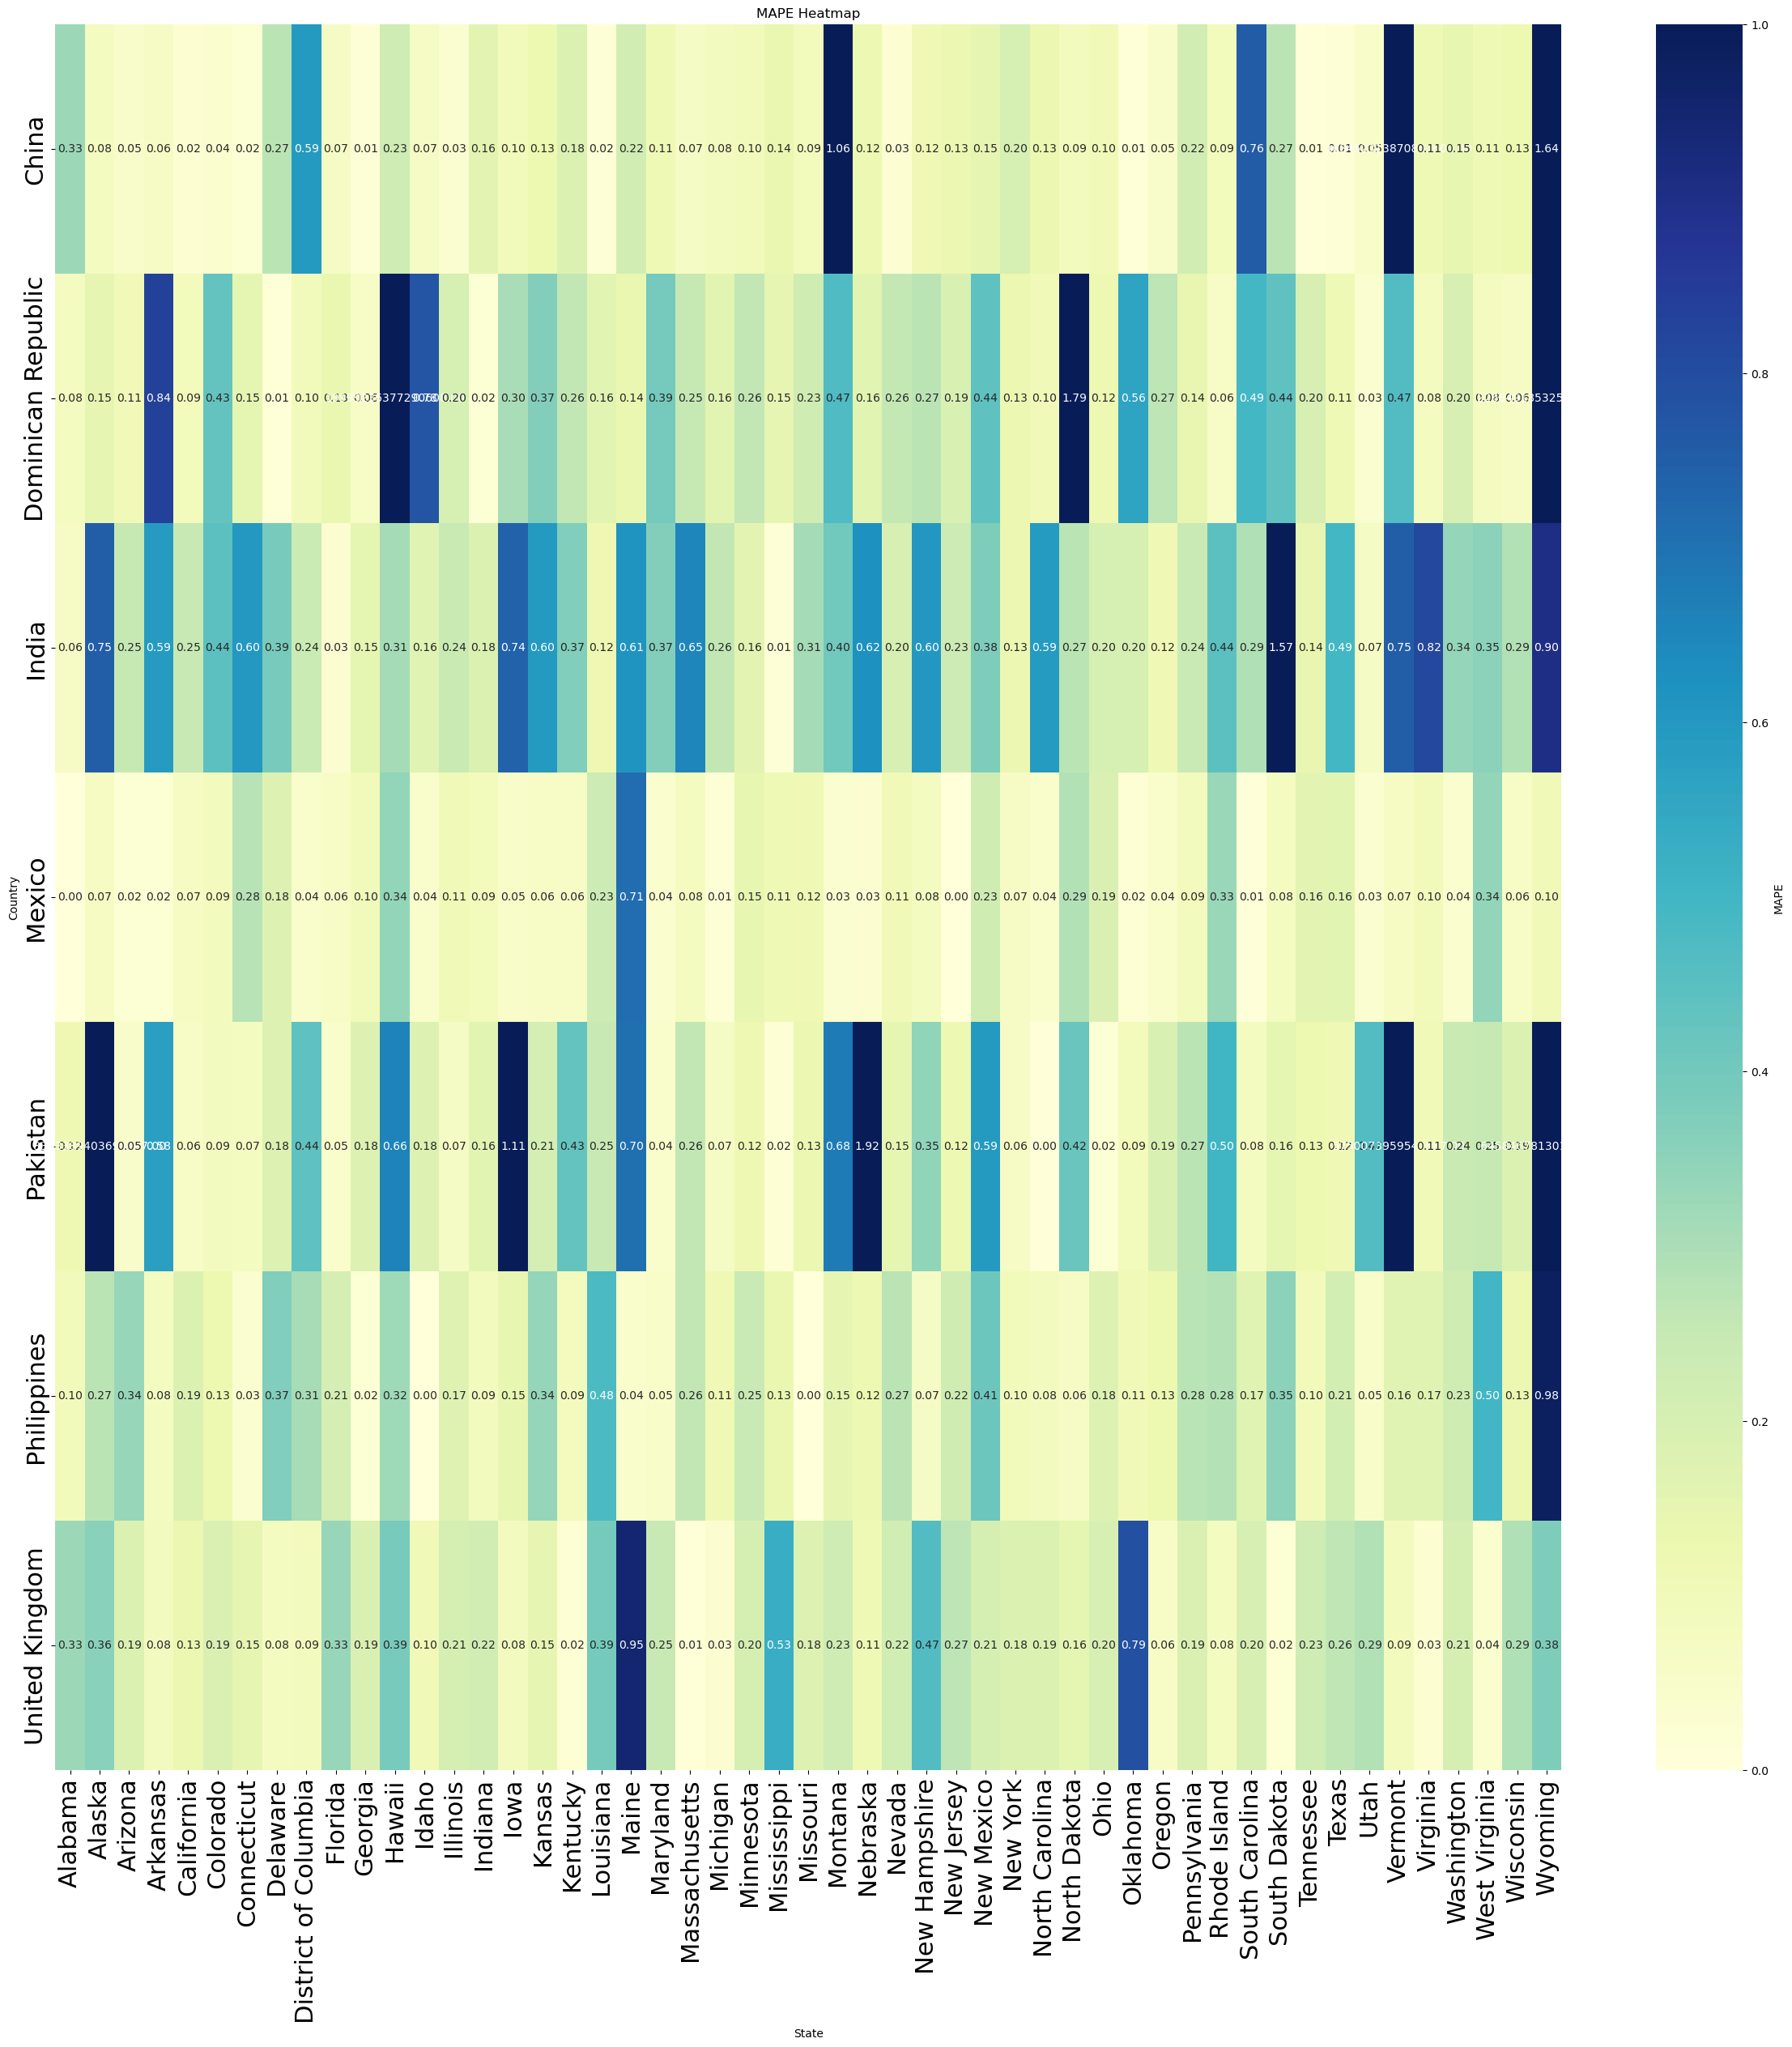

In [18]:


#results_df["pred2023"] = results_df["pred2023"].astype(int)
#results_df["pred2019"] = results_df["pred2019"].astype(int)
display(results_df)
print(results_df.describe())

import seaborn as sns
# Reshape the DataFrame to a pivot table for the heatmap
heatmap_df = results_df.pivot(index='Country', columns='State', values='MAPE')  # You can choose 'MAPE' here if needed

# Plot the heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'MAPE'},vmin=0, vmax=1)  # You can choose 'MAPE' here if needed
plt.title('MAPE Heatmap')
plt.xlabel('State')
plt.ylabel('Country')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.show()

In [19]:
display(results_df[(results_df['State'] == 'Wyoming') & (results_df['Country'] == 'Philippines')])

,Country,State,MAE,MAPE,pred2023,CVRMSE,MEDAE,MSE,RMSE,data2019,pred2019
356,Philippines,Wyoming,30.422731,0.981378,[36.10320684113119],98.13784,30.422731,925.542532,30.422731,[31],[61.422730514656806]


In [20]:
display(results_df[(results_df['State'] == 'West Virginia') & (results_df['Country'] == 'Dominican Republic')])

,Country,State,MAE,MAPE,pred2023,CVRMSE,MEDAE,MSE,RMSE,data2019,pred2019
150,Dominican Republic,West Virginia,0.704329,0.078259,[9.334920680278117],7.825872,0.704329,0.496079,0.704329,[9],[8.295671488114573]


In [24]:
display(results_df[(results_df['State'] == 'California') & (results_df['Country'] == 'United Kingdom')])

,Country,State,MAE,MAPE,pred2023,CVRMSE,MEDAE,MSE,RMSE,data2019,pred2019
208,United Kingdom,California,283.62246,0.131979,[1180.4853187222693],13.197881,283.62246,80441.699678,283.62246,[2149],[1865.3775402442495]


In [22]:
mape_condition = results_df['MAPE'] < 0.3

# Group by 'Country' and 'State', and count the valid combinations
num_combinations_with_low_mape = results_df[mape_condition].groupby(['Country', 'State']).size().reset_index(name='Count')

print(num_combinations_with_low_mape)

            Country          State  Count
0             China         Alaska      1
1             China        Arizona      1
2             China       Arkansas      1
3             China     California      1
4             China       Colorado      1
..              ...            ...    ...
265  United Kingdom        Vermont      1
266  United Kingdom       Virginia      1
267  United Kingdom     Washington      1
268  United Kingdom  West Virginia      1
269  United Kingdom      Wisconsin      1

[270 rows x 3 columns]


In [23]:

results_df.to_csv("Output/output_data_2019_metrics.csv", index=False)

In [ ]:
# Close the database connection
conn.close()